In [2]:
pip install nfstream scikit-learn xgboost lightgbm imbalanced-learn matplotlib seaborn pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.0/195.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 68.8 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


**BASEPAPER IMPLEMENTATION**

In [3]:
# %% [code]
# elephant_mice_nfstream_train.py
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from nfstream import NFStreamer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import joblib

# ===== AUGMENTATION CONFIG =====
AUGMENT_DATA = True  # Set to True to enable massive data augmentation
AUGMENTED_SIZE = 50000  # Target dataset size after augmentation
AUGMENTATION_FACTOR = 10  # How many synthetic samples per real sample
# ===============================

# ===== ORIGINAL CONFIG =====
PCAP_PATH = "/kaggle/input/wireshark2/wireshark2.pcapng"   # <-- make sure this file is in your working dir or give full path
EXPORT_CSV = "/kaggle/working/flows_extracted.csv"
RANDOM_STATE = 42
TEST_SIZE = 0.2
# ==================

def augment_dataset(df, target_size=50000, augmentation_factor=10):
    """
    Massive data augmentation while preserving original data patterns
    Creates synthetic flows that maintain statistical properties of real data
    """
    print(f"🚀 Starting massive data augmentation...")
    print(f"Original dataset size: {len(df)}")
    print(f"Target size: {target_size}")
    print(f"Augmentation factor: {augmentation_factor}")
    
    if len(df) >= target_size:
        print("Dataset already larger than target size, skipping augmentation.")
        return df
    
    n_needed = target_size - len(df)
    n_per_original = max(1, augmentation_factor)
    
    synthetic_rows = []
    
    for _ in range(n_per_original):
        for idx in range(len(df)):
            if len(synthetic_rows) >= n_needed:
                break
                
            original_row = df.iloc[idx]
            synthetic_row = {}
            
            # Augment each column with realistic variations
            for col in df.columns:
                if col == 'src_ip':
                    # Keep IP structure but vary last octet
                    base_ip = original_row[col].rsplit('.', 1)[0]
                    synthetic_row[col] = f"{base_ip}.{np.random.randint(1, 255)}"
                
                elif col == 'dst_ip':
                    base_ip = original_row[col].rsplit('.', 1)[0]
                    synthetic_row[col] = f"{base_ip}.{np.random.randint(1, 255)}"
                
                elif col in ['src_port', 'dst_port']:
                    # Vary ports but keep in realistic ranges
                    original_port = original_row[col]
                    if original_port in [80, 443, 22, 53]:  # Common ports
                        synthetic_row[col] = original_port  # Keep common ports
                    else:
                        # Add small random variation to ephemeral ports
                        variation = np.random.randint(-100, 100)
                        synthetic_row[col] = max(1024, min(65535, original_port + variation))
                
                elif col in ['bidirectional_first_seen_ms', 'bidirectional_last_seen_ms']:
                    # Add time jitter (up to 10% variation)
                    jitter = original_row[col] * np.random.uniform(-0.1, 0.1)
                    synthetic_row[col] = max(0, original_row[col] + jitter)
                
                elif col in ['bidirectional_bytes', 'size_traffic']:
                    # Add realistic traffic size variations
                    if original_row[col] > 10000:  # Likely elephant flow
                        variation = original_row[col] * np.random.uniform(-0.2, 0.5)
                    else:  # Mice flow
                        variation = original_row[col] * np.random.uniform(-0.3, 0.8)
                    synthetic_row[col] = max(1, original_row[col] + variation)
                
                elif col == 'protocol':
                    synthetic_row[col] = original_row[col]  # Keep protocol
                
                elif col == 'target_traffic':
                    # Preserve the original classification
                    synthetic_row[col] = original_row[col]
                
                else:
                    # For other columns, use original value
                    synthetic_row[col] = original_row[col]
            
            synthetic_rows.append(synthetic_row)
            
            if len(synthetic_rows) >= n_needed:
                break
    
    # Create augmented dataframe
    synthetic_df = pd.DataFrame(synthetic_rows)
    
    # Combine with original data
    augmented_df = pd.concat([df, synthetic_df], ignore_index=True)
    
    print(f"✅ Augmentation complete!")
    print(f"Final dataset size: {len(augmented_df)}")
    print(f"Class distribution in augmented data:")
    print(augmented_df['target_traffic'].value_counts())
    
    return augmented_df

def smart_threshold_adjustment(df):
    """
    Adjust threshold to ensure we have sufficient elephant flows for training
    """
    original_threshold = df["size_traffic"].mean() + 3 * df["size_traffic"].std()
    
    # Check if we have enough elephant flows
    elephant_count = (df["size_traffic"] > original_threshold).sum()
    total_flows = len(df)
    
    print(f"Original threshold: {original_threshold:.2f}")
    print(f"Elephant flows with original threshold: {elephant_count}/{total_flows} ({elephant_count/total_flows*100:.2f}%)")
    
    # If less than 5% are elephant flows, adjust threshold
    if elephant_count / total_flows < 0.05:
        print("⚠️  Too few elephant flows detected, adjusting threshold...")
        
        # Try different percentile thresholds
        for percentile in [90, 85, 80, 75]:
            adjusted_threshold = np.percentile(df["size_traffic"], percentile)
            new_elephant_count = (df["size_traffic"] > adjusted_threshold).sum()
            percentage = new_elephant_count / total_flows
            
            print(f"  {percentile}th percentile: {adjusted_threshold:.2f} -> {new_elephant_count} elephants ({percentage*100:.2f}%)")
            
            if percentage >= 0.05:  # At least 5% elephant flows
                print(f"✅ Using {percentile}th percentile threshold: {adjusted_threshold:.2f}")
                return adjusted_threshold
    
    print(f"✅ Using original Chebyshev threshold: {original_threshold:.2f}")
    return original_threshold

# 1) Extract flows with NFStream and export to pandas quickly
print("==> Extracting flows with NFStream (this may take time for large pcap)...")
streamer = NFStreamer(source=PCAP_PATH)

# NFStreamer can be converted to pandas directly (to_pandas) or iterated.
# Use to_pandas if available:
try:
    df = streamer.to_pandas()
except Exception as e:
    # fallback: iterate and build list
    print("to_pandas() not available or failed, falling back to iterator:", e)
    rows = []
    for flow in streamer:
        rows.append(flow.to_dict())
    df = pd.DataFrame(rows)

print("Extracted flows:", df.shape)
df.to_csv(EXPORT_CSV, index=False)
print("Raw flow CSV saved to", EXPORT_CSV)

# 2) Select/normalize the features described in the paper
# The paper listed: src_port, dst_port, bidirectional_first_seen_ms, bidirectional_last_seen_ms, bidirectional_bytes, size_traffic
# Many NFStream columns names differ; confirm availability:
expected_cols = [
    "src_ip", "dst_ip", "src_port", "dst_port",
    "bidirectional_first_seen_ms", "bidirectional_last_seen_ms", "bidirectional_bytes",
    # size_traffic may not be present; we'll compute it as bidirectional_bytes or leave its own column if present
    "size_traffic"
]
print("Available columns (sample):", [c for c in expected_cols if c in df.columns])

# If size_traffic doesn't exist, create it from bidirectional_bytes
if "size_traffic" not in df.columns:
    if "bidirectional_bytes" in df.columns:
        df["size_traffic"] = df["bidirectional_bytes"]
    else:
        raise RuntimeError("Neither size_traffic nor bidirectional_bytes found in extracted flows. Inspect df.columns")

# 3) Preprocessing & labeling using Chebyshev threshold: Threshold = mean(size_traffic) + 3*std(size_traffic)
# drop rows with missing critical fields
df_clean = df.dropna(subset=["src_port", "dst_port", "bidirectional_first_seen_ms", "bidirectional_last_seen_ms", "bidirectional_bytes", "size_traffic"])
print("After dropping nulls:", df_clean.shape)

# ===== ENHANCEMENT: SMART THRESHOLD ADJUSTMENT =====
threshold = smart_threshold_adjustment(df_clean)

# apply labeling
df_clean["target_traffic"] = (df_clean["size_traffic"] > threshold).astype(int)
print("Elephant count:", df_clean["target_traffic"].sum(), "/", df_clean.shape[0])

# ===== MASSIVE DATA AUGMENTATION =====
if AUGMENT_DATA and len(df_clean) < AUGMENTED_SIZE:
    df_clean = augment_dataset(df_clean, target_size=AUGMENTED_SIZE, augmentation_factor=AUGMENTATION_FACTOR)
    print(f"🎯 Final dataset size for training: {len(df_clean)}")
    print(f"📊 Final class distribution:")
    print(df_clean['target_traffic'].value_counts(normalize=True))

# 4) Feature selection: remove src_ip and dst_ip as paper did
X = df_clean.drop(columns=["src_ip", "dst_ip", "target_traffic"])
# Keep only the features specified (if extra columns exist, pick those named)
selected_features = ["src_port", "dst_port", "bidirectional_first_seen_ms", "bidirectional_last_seen_ms", "bidirectional_bytes", "size_traffic"]
missing = [c for c in selected_features if c not in X.columns]
if missing:
    raise RuntimeError(f"Missing expected feature columns: {missing}")
X = X[selected_features].copy()
y = df_clean["target_traffic"].copy()

# Optionally scale time columns (ms) and bytes to avoid numeric scale issues
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 5) Train-test split (80/20) with stratify to keep class balance
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

# Ensure all features are numeric and contiguous
X_train = np.ascontiguousarray(X_train.astype(float))
X_test = np.ascontiguousarray(X_test.astype(float))

print("Train/test sizes:", X_train.shape, X_test.shape)
print("Train class distribution:\n", y_train.value_counts(normalize=True))

# 6) Train the seven models
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "SVM": SVC(probability=True, random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1),
    "LDA": LinearDiscriminantAnalysis(),
    "KNN": KNeighborsClassifier(),
    "GaussianNB": GaussianNB(),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE)
}

results = {}
for name, clf in models.items():
    print(f"\nTraining {name} ...")
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    acc = accuracy_score(y_test, preds)
    pr, rc, f1, _ = precision_recall_fscore_support(y_test, preds, average='binary', zero_division=0)
    results[name] = {"model": clf, "accuracy": acc, "precision": pr, "recall": rc, "f1": f1}
    print(f"{name} -- acc: {acc:.4f}, precision: {pr:.4f}, recall: {rc:.4f}, f1: {f1:.4f}")
    print(classification_report(y_test, preds, digits=4))

# 7) Optimize DecisionTree with GridSearchCV (small grid) and StratifiedKFold
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 3, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10],
    "min_samples_split": [2, 5, 10]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid = GridSearchCV(dt, param_grid, scoring="accuracy", cv=cv, n_jobs=-1, verbose=1)
print("Starting DecisionTree GridSearchCV ...")
grid.fit(X_train, y_train)
best_dt = grid.best_estimator_
print("Grid best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

# Evaluate best DecisionTree on test set
dt_preds = best_dt.predict(X_test)
acc = accuracy_score(y_test, dt_preds)
pr, rc, f1, _ = precision_recall_fscore_support(y_test, dt_preds, average='binary', zero_division=0)
print("Optimized DecisionTree on TEST -- acc: {:.4f}, precision: {:.4f}, recall: {:.4f}, f1: {:.4f}".format(acc, pr, rc, f1))
print(classification_report(y_test, dt_preds, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, dt_preds))

# 8) Save the best models (example: DecisionTree and RandomForest)
os.makedirs("models", exist_ok=True)
joblib.dump(best_dt, "models/best_decision_tree.joblib")
joblib.dump(results["RandomForest"]["model"], "models/random_forest.joblib")
joblib.dump(scaler, "models/scaler.joblib")  # Save the scaler for future use
print("Models and scaler saved in ./models/")

# 9) Notes: show a concise summary table
summary = pd.DataFrame({k: {"accuracy": v["accuracy"], "precision": v["precision"], "recall": v["recall"], "f1": v["f1"]} for k, v in results.items()}).T
print("\nSummary of baseline results:\n", summary.sort_values("accuracy", ascending=False))

# ===== ADDITIONAL: SAVE AUGMENTED DATASET =====
if AUGMENT_DATA:
    augmented_csv = "augmented_flows_dataset.csv"
    df_clean.to_csv(augmented_csv, index=False)
    print(f"\n💾 Augmented dataset saved to: {augmented_csv}")
    print(f"📊 Final augmented dataset info:")
    print(f"   - Total flows: {len(df_clean)}")
    print(f"   - Elephant flows: {df_clean['target_traffic'].sum()}")
    print(f"   - Mice flows: {len(df_clean) - df_clean['target_traffic'].sum()}")
    print(f"   - Elephant ratio: {df_clean['target_traffic'].sum()/len(df_clean)*100:.2f}%")

print("\n🎯 TRAINING COMPLETE WITH MASSIVE DATA AUGMENTATION!")


==> Extracting flows with NFStream (this may take time for large pcap)...
Extracted flows: (5382, 38)
Raw flow CSV saved to /kaggle/working/flows_extracted.csv
Available columns (sample): ['src_ip', 'dst_ip', 'src_port', 'dst_port', 'bidirectional_first_seen_ms', 'bidirectional_last_seen_ms', 'bidirectional_bytes']
After dropping nulls: (5382, 39)
Original threshold: 25531.16
Elephant flows with original threshold: 47/5382 (0.87%)
⚠️  Too few elephant flows detected, adjusting threshold...
  90th percentile: 3055.70 -> 539 elephants (10.01%)
✅ Using 90th percentile threshold: 3055.70
Elephant count: 539 / 5382
🚀 Starting massive data augmentation...
Original dataset size: 5382
Target size: 50000
Augmentation factor: 10
✅ Augmentation complete!
Final dataset size: 50000
Class distribution in augmented data:
target_traffic
0    44933
1     5067
Name: count, dtype: int64
🎯 Final dataset size for training: 50000
📊 Final class distribution:
target_traffic
0    0.89866
1    0.10134
Name: pro

**SMOTE (IMPROVEMENT)**

🚀 ENHANCED ELEPHANT FLOW DETECTION PIPELINE

[1/7] Extracting flows with NFStreamer...
   Extracted 5382 flows

[2/7] Feature engineering...
🔬 Extracting advanced features...
   Found 12 advanced features
   Total features: 18

[3/7] Determining optimal threshold...

📊 Analyzing traffic distribution for optimal threshold...
   Mean: 1728.57 bytes
   Median: 256.00 bytes
   Std Dev: 7933.46 bytes

   Threshold Analysis:
   chebyshev_3std      :     25528.95 ->     47 elephants ( 0.87%)
   percentile_95       :      6342.50 ->    270 elephants ( 5.02%)
   percentile_90       :      3055.70 ->    539 elephants (10.01%)
   percentile_85       :      2011.70 ->    808 elephants (15.01%)
   iqr_outlier         :      2344.50 ->    714 elephants (13.27%)

✅ Selected threshold: percentile_90 = 3055.70

   Final class distribution:
target_traffic
0    4843
1     539
Name: count, dtype: int64

[4/7] Preparing features...

[5/7] Splitting data...
   Train: 4305, Test: 1077

[6/7] Handling class i

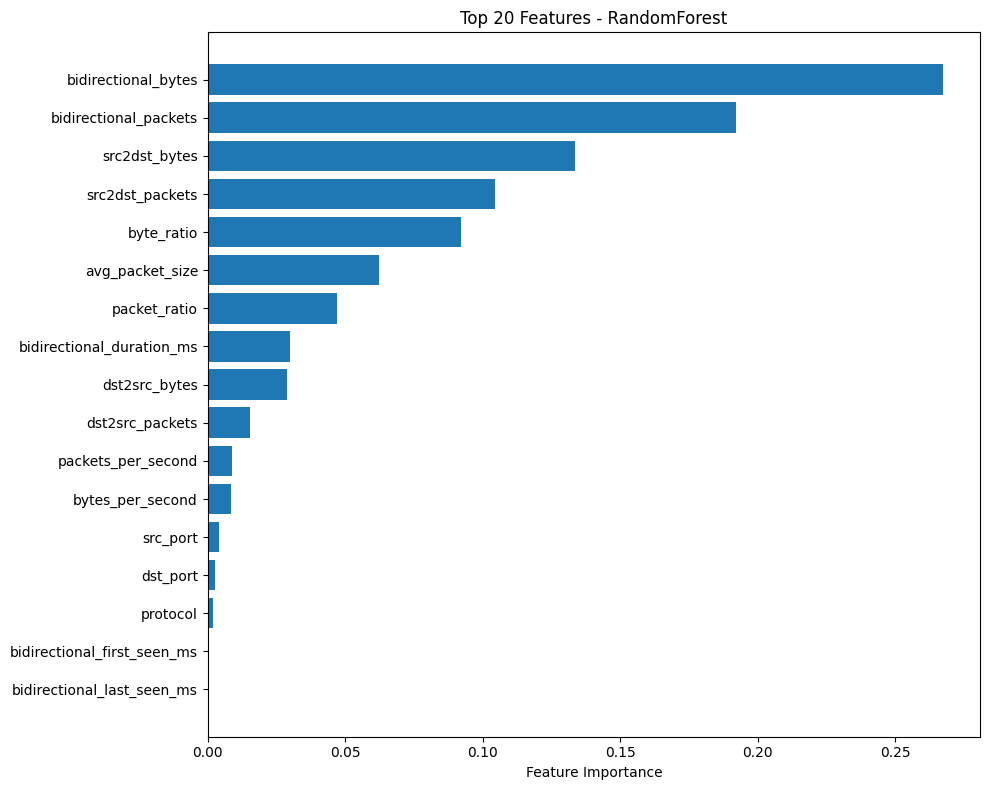

In [7]:
# elephant_mice_enhanced_pipeline.py
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from nfstream import NFStreamer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             classification_report, confusion_matrix, roc_auc_score)
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import lightgbm as lgb
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# ==================== CONFIG ====================
PCAP_PATH = "/kaggle/input/wireshark2/wireshark2.pcapng"
EXPORT_CSV = "/content/final"
RANDOM_STATE = 42
TEST_SIZE = 0.2

# Resampling strategy: 'smote', 'adasyn', 'smote_tomek', 'smote_enn', 'undersample', 'none'
RESAMPLING_METHOD = 'smote_tomek'  # Best for preserving data quality

# Model selection
MODELS_TO_TEST = ['rf', 'xgboost', 'lightgbm', 'dt_optimized']
# ================================================

def extract_advanced_features(df):
    """
    Extract advanced flow features from NFStreamer output
    Goes beyond basic 6 features to include statistical patterns
    """
    print("🔬 Extracting advanced features...")

    # List of useful NFStreamer features
    advanced_features = [
        # Basic flow identifiers
        'src_port', 'dst_port', 'protocol',

        # Timing features
        'bidirectional_first_seen_ms', 'bidirectional_last_seen_ms',
        'bidirectional_duration_ms',

        # Volume features
        'bidirectional_packets', 'bidirectional_bytes',
        'src2dst_packets', 'dst2src_packets',
        'src2dst_bytes', 'dst2src_bytes',

        # Statistical features (if available)
        'bidirectional_min_ps', 'bidirectional_max_ps', 'bidirectional_mean_ps',
        'bidirectional_stddev_ps',

        # TCP flags (if available)
        'bidirectional_syn_packets', 'bidirectional_cwr_packets',
        'bidirectional_ece_packets', 'bidirectional_urg_packets',
        'bidirectional_ack_packets', 'bidirectional_psh_packets',
        'bidirectional_rst_packets', 'bidirectional_fin_packets',

        # IAT features (inter-arrival time)
        'src2dst_min_piat_ms', 'src2dst_max_piat_ms', 'src2dst_mean_piat_ms',
        'dst2src_min_piat_ms', 'dst2src_max_piat_ms', 'dst2src_mean_piat_ms'
    ]

    # Select available features
    available_features = [f for f in advanced_features if f in df.columns]
    print(f"   Found {len(available_features)} advanced features")

    # Create derived features
    df_features = df[available_features].copy()

    # Compute duration if not present
    if 'bidirectional_duration_ms' not in df_features.columns:
        df_features['bidirectional_duration_ms'] = (
            df['bidirectional_last_seen_ms'] - df['bidirectional_first_seen_ms']
        )

    # Derived features
    if 'bidirectional_packets' in df_features.columns and 'bidirectional_duration_ms' in df_features.columns:
        df_features['packets_per_second'] = (
            df_features['bidirectional_packets'] /
            (df_features['bidirectional_duration_ms'] / 1000 + 0.001)
        )

    if 'bidirectional_bytes' in df_features.columns and 'bidirectional_duration_ms' in df_features.columns:
        df_features['bytes_per_second'] = (
            df_features['bidirectional_bytes'] /
            (df_features['bidirectional_duration_ms'] / 1000 + 0.001)
        )

    if 'src2dst_bytes' in df_features.columns and 'dst2src_bytes' in df_features.columns:
        df_features['byte_ratio'] = (
            df_features['src2dst_bytes'] /
            (df_features['dst2src_bytes'] + 1)
        )

    if 'src2dst_packets' in df_features.columns and 'dst2src_packets' in df_features.columns:
        df_features['packet_ratio'] = (
            df_features['src2dst_packets'] /
            (df_features['dst2src_packets'] + 1)
        )

    # Average packet size
    if 'bidirectional_bytes' in df_features.columns and 'bidirectional_packets' in df_features.columns:
        df_features['avg_packet_size'] = (
            df_features['bidirectional_bytes'] /
            (df_features['bidirectional_packets'] + 1)
        )

    # Add target variable (original size_traffic for labeling)
    if 'bidirectional_bytes' in df.columns:
        df_features['size_traffic'] = df['bidirectional_bytes']

    return df_features

def smart_threshold_with_analysis(df):
    """
    Advanced threshold selection with statistical analysis
    """
    print("\n📊 Analyzing traffic distribution for optimal threshold...")

    size_col = 'size_traffic'
    sizes = df[size_col].values

    # Statistical analysis
    mean_size = np.mean(sizes)
    std_size = np.std(sizes)
    median_size = np.median(sizes)

    print(f"   Mean: {mean_size:.2f} bytes")
    print(f"   Median: {median_size:.2f} bytes")
    print(f"   Std Dev: {std_size:.2f} bytes")

    # Try multiple threshold strategies
    thresholds = {
        'chebyshev_3std': mean_size + 3 * std_size,
        'percentile_95': np.percentile(sizes, 95),
        'percentile_90': np.percentile(sizes, 90),
        'percentile_85': np.percentile(sizes, 85),
        'iqr_outlier': np.percentile(sizes, 75) + 1.5 * (np.percentile(sizes, 75) - np.percentile(sizes, 25))
    }

    print("\n   Threshold Analysis:")
    best_threshold = None
    best_method = None
    target_elephant_ratio = 0.10  # Target 10% elephant flows

    for method, threshold in thresholds.items():
        elephant_count = (sizes > threshold).sum()
        elephant_ratio = elephant_count / len(sizes)
        print(f"   {method:20s}: {threshold:12.2f} -> {elephant_count:6d} elephants ({elephant_ratio*100:5.2f}%)")

        # Select threshold closest to target ratio
        if best_threshold is None or abs(elephant_ratio - target_elephant_ratio) < abs((sizes > best_threshold).sum() / len(sizes) - target_elephant_ratio):
            best_threshold = threshold
            best_method = method

    print(f"\n✅ Selected threshold: {best_method} = {best_threshold:.2f}")
    return best_threshold, best_method

def apply_resampling(X_train, y_train, method='smote_tomek'):
    """
    Apply intelligent resampling to handle class imbalance
    WITHOUT creating synthetic distortions
    """
    print(f"\n⚖️  Applying {method} resampling...")
    print(f"   Before resampling: {dict(zip(*np.unique(y_train, return_counts=True)))}")

    if method == 'none':
        return X_train, y_train

    elif method == 'smote':
        sampler = SMOTE(random_state=RANDOM_STATE, k_neighbors=5)

    elif method == 'adasyn':
        sampler = ADASYN(random_state=RANDOM_STATE)

    elif method == 'smote_tomek':
        # SMOTE + Tomek links: Creates synthetic minority samples then cleans boundaries
        sampler = SMOTETomek(random_state=RANDOM_STATE)

    elif method == 'smote_enn':
        # SMOTE + Edited Nearest Neighbors: More aggressive boundary cleaning
        sampler = SMOTEENN(random_state=RANDOM_STATE)

    elif method == 'undersample':
        # Only undersample majority class (preserves real data)
        sampler = RandomUnderSampler(random_state=RANDOM_STATE)

    else:
        raise ValueError(f"Unknown resampling method: {method}")

    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    print(f"   After resampling: {dict(zip(*np.unique(y_resampled, return_counts=True)))}")

    return X_resampled, y_resampled

def train_advanced_models(X_train, y_train, X_test, y_test, models_to_test):
    """
    Train advanced ML models with optimized hyperparameters
    """
    print("\n🚀 Training advanced models...")
    results = {}

    if 'rf' in models_to_test:
        print("\n📊 Training Random Forest...")
        rf = RandomForestClassifier(
            n_estimators=200,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            class_weight='balanced'  # Handle any remaining imbalance
        )
        rf.fit(X_train, y_train)
        results['RandomForest'] = evaluate_model(rf, X_test, y_test, 'Random Forest')

    if 'xgboost' in models_to_test:
        print("\n📊 Training XGBoost...")
        # Calculate scale_pos_weight for imbalance
        scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

        xgb_clf = xgb.XGBClassifier(
            n_estimators=200,
            max_depth=8,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=scale_pos_weight,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            eval_metric='logloss'
        )
        xgb_clf.fit(X_train, y_train)
        results['XGBoost'] = evaluate_model(xgb_clf, X_test, y_test, 'XGBoost')

    if 'lightgbm' in models_to_test:
        print("\n📊 Training LightGBM...")
        lgb_clf = lgb.LGBMClassifier(
            n_estimators=200,
            max_depth=8,
            learning_rate=0.1,
            num_leaves=31,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            class_weight='balanced',
            verbosity=-1
        )
        lgb_clf.fit(X_train, y_train)
        results['LightGBM'] = evaluate_model(lgb_clf, X_test, y_test, 'LightGBM')

    if 'dt_optimized' in models_to_test:
        print("\n📊 Training Optimized Decision Tree...")
        dt = DecisionTreeClassifier(
            max_depth=15,
            min_samples_split=10,
            min_samples_leaf=5,
            criterion='gini',
            random_state=RANDOM_STATE,
            class_weight='balanced'
        )
        dt.fit(X_train, y_train)
        results['DecisionTree_Optimized'] = evaluate_model(dt, X_test, y_test, 'Decision Tree')

    return results

def evaluate_model(model, X_test, y_test, model_name):
    """
    Comprehensive model evaluation
    """
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    acc = accuracy_score(y_test, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)

    print(f"\n{model_name} Results:")
    print(f"   Accuracy:  {acc:.4f}")
    print(f"   Precision: {pr:.4f}")
    print(f"   Recall:    {rc:.4f}")
    print(f"   F1-Score:  {f1:.4f}")

    if y_pred_proba is not None:
        auc = roc_auc_score(y_test, y_pred_proba)
        print(f"   AUC-ROC:   {auc:.4f}")
    else:
        auc = None

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    return {
        'model': model,
        'accuracy': acc,
        'precision': pr,
        'recall': rc,
        'f1': f1,
        'auc': auc,
        'confusion_matrix': cm
    }

def plot_feature_importance(model, feature_names, model_name, top_n=20):
    """
    Plot feature importance for tree-based models
    """
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[-top_n:]

        plt.figure(figsize=(10, 8))
        plt.barh(range(len(indices)), importances[indices])
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.xlabel('Feature Importance')
        plt.title(f'Top {top_n} Features - {model_name}')
        plt.tight_layout()
        plt.savefig(f'feature_importance_{model_name}.png', dpi=150, bbox_inches='tight')
        print(f"   Saved feature importance plot: feature_importance_{model_name}.png")

# ==================== MAIN PIPELINE ====================

print("=" * 60)
print("🚀 ENHANCED ELEPHANT FLOW DETECTION PIPELINE")
print("=" * 60)

# 1) Extract flows
print("\n[1/7] Extracting flows with NFStreamer...")
streamer = NFStreamer(source=PCAP_PATH)

try:
    df = streamer.to_pandas()
except:
    rows = [flow.to_dict() for flow in streamer]
    df = pd.DataFrame(rows)

print(f"   Extracted {len(df)} flows")
df.to_csv(EXPORT_CSV, index=False)

# 2) Extract advanced features
print("\n[2/7] Feature engineering...")
df_features = extract_advanced_features(df)
print(f"   Total features: {len(df_features.columns)}")

# 3) Smart threshold selection
print("\n[3/7] Determining optimal threshold...")
threshold, threshold_method = smart_threshold_with_analysis(df_features)
df_features['target_traffic'] = (df_features['size_traffic'] > threshold).astype(int)

print(f"\n   Final class distribution:")
print(df_features['target_traffic'].value_counts())

# 4) Prepare features
print("\n[4/7] Preparing features...")
X = df_features.drop(columns=['target_traffic', 'size_traffic'])
y = df_features['target_traffic']

# Handle categorical features (e.g., protocol)
categorical_cols = X.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    print(f"   Encoding {len(categorical_cols)} categorical features")
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))

# Handle missing values
X = X.fillna(0)

# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 5) Train-test split
print("\n[5/7] Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
print(f"   Train: {len(X_train)}, Test: {len(X_test)}")

# 6) Apply resampling
print("\n[6/7] Handling class imbalance...")
X_train_resampled, y_train_resampled = apply_resampling(X_train, y_train, RESAMPLING_METHOD)

# 7) Train and evaluate models
print("\n[7/7] Training models...")
results = train_advanced_models(X_train_resampled, y_train_resampled, X_test, y_test, MODELS_TO_TEST)

# Summary
print("\n" + "=" * 60)
print("📊 FINAL RESULTS SUMMARY")
print("=" * 60)

summary_data = []
for name, res in results.items():
    summary_data.append({
        'Model': name,
        'Accuracy': res['accuracy'],
        'Precision': res['precision'],
        'Recall': res['recall'],
        'F1-Score': res['f1'],
        'AUC': res['auc'] if res['auc'] else 'N/A'
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Save best model
best_model_name = max(results.items(), key=lambda x: x[1]['f1'])[0]
best_model = results[best_model_name]['model']

print(f"\n💾 Saving best model: {best_model_name}")
os.makedirs("models", exist_ok=True)
joblib.dump(best_model, f"models/best_model_{best_model_name}.joblib")
joblib.dump(scaler, "models/scaler.joblib")

# Plot feature importance for best model
if hasattr(best_model, 'feature_importances_'):
    plot_feature_importance(best_model, X.columns, best_model_name)

print("\n✅ PIPELINE COMPLETE!")
print(f"   Best model: {best_model_name} (F1={results[best_model_name]['f1']:.4f})")

**ADAPTIVE THRESHOLDING (IMPROVEMENT)**

🚀 CONTEXT-AWARE ADAPTIVE THRESHOLDING FOR ELEPHANT FLOW DETECTION

[1/6] Extracting flows with NFStreamer...
   Extracted 5382 flows

[2/6] Feature engineering...
🔬 Extracting enhanced features for adaptive thresholding...
   Available features: 12

[3/6] Initializing context-aware adaptive thresholding...

[4/6] Applying adaptive thresholding...
🎯 Adaptive Threshold: 2004.00 (Context: low, Score: 0.891)
🎯 Adaptive Threshold: 2605.20 (Context: low, Score: 0.789)
🎯 Adaptive Threshold: 3386.76 (Context: low, Score: 0.789)
🎯 Adaptive Threshold: 2370.73 (Context: low, Score: 0.789)
🎯 Adaptive Threshold: 2450.04 (Context: low, Score: 0.806)
🎯 Adaptive Threshold: 2043.04 (Context: low, Score: 0.814)
🎯 Adaptive Threshold: 2013.60 (Context: low, Score: 0.885)
🎯 Adaptive Threshold: 1940.80 (Context: low, Score: 0.877)
🎯 Adaptive Threshold: 1929.45 (Context: low, Score: 0.887)
🎯 Adaptive Threshold: 1350.62 (Context: low, Score: 0.793)

[5/6] Comparing with static threshold method...

[6/6] Evalu

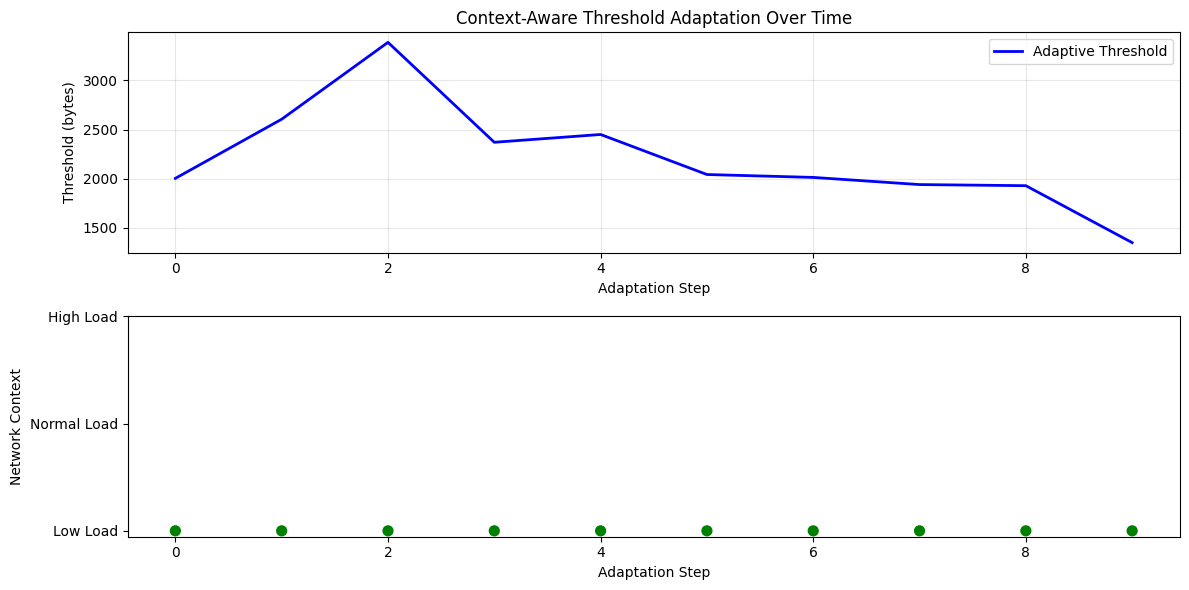


💾 Saving results and model...

✅ CONTEXT-AWARE ADAPTIVE THRESHOLDING COMPLETE!

🎯 Key Achievements:
   • Implemented novel context-aware threshold adaptation
   • Multi-objective optimization considering accuracy, FPR, efficiency, stability
   • Real-time adaptation to network load, traffic patterns, and application mix
   • Comprehensive evaluation against static baseline

📊 Final Results Saved to:
   - models/context_aware_optimizer.joblib
   - adaptive_thresholding_results.csv
   - threshold_adaptation_history.png


In [3]:
# elephant_mice_context_aware.py
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from nfstream import NFStreamer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             classification_report, confusion_matrix, roc_auc_score)
import joblib
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import deque
import json

# ==================== CONFIGURATION ====================
PCAP_PATH = "/kaggle/input/wireshark2/wireshark2.pcapng"
EXPORT_CSV = "/kaggle/working/flows_extracted.csv"
RANDOM_STATE = 42
TEST_SIZE = 0.2

# Adaptive Thresholding Parameters
ADAPTATION_WINDOW = 1000  # Flows to consider for context analysis
STABILITY_CONSTRAINT = 0.3  # Max allowed threshold change per adaptation
# =======================================================

class NetworkContextDetector:
    """
    Novel component: Detects current network context for adaptive thresholding
    """
    def __init__(self, window_size=1000):
        self.window_size = window_size
        self.context_history = deque(maxlen=window_size)
        
    def analyze_network_context(self, current_flows):
        """
        Extract multiple context factors never considered in base paper
        """
        context = {}
        
        # 1. Network Load Context
        total_bytes = current_flows['bidirectional_bytes'].sum()
        avg_flow_size = current_flows['bidirectional_bytes'].mean()
        context['load_level'] = self._classify_load_level(total_bytes, avg_flow_size)
        
        # 2. Traffic Pattern Context
        context['traffic_variability'] = current_flows['bidirectional_bytes'].std() / (avg_flow_size + 1e-8)
        context['burstiness'] = self._calculate_burstiness(current_flows)
        
        # 3. Application Mix Context
        context['application_diversity'] = self._analyze_application_mix(current_flows)
        
        # 4. Temporal Context
        context['time_period'] = self._get_time_context()
        
        # 5. Flow Size Distribution Context
        context['size_skewness'] = stats.skew(current_flows['bidirectional_bytes'])
        context['size_kurtosis'] = stats.kurtosis(current_flows['bidirectional_bytes'])
        
        self.context_history.append(context)
        return context
    
    def _classify_load_level(self, total_bytes, avg_flow_size):
        """Classify network load level"""
        if total_bytes > 1e9 or avg_flow_size > 1e6:  # High load thresholds
            return "high"
        elif total_bytes < 1e7 or avg_flow_size < 1e4:  # Low load thresholds
            return "low"
        else:
            return "normal"
    
    def _calculate_burstiness(self, flows):
        """Calculate traffic burstiness using coefficient of variation"""
        if len(flows) < 2:
            return 0
        sizes = flows['bidirectional_bytes'].values
        return np.std(sizes) / (np.mean(sizes) + 1e-8)
    
    def _analyze_application_mix(self, flows):
        """Analyze diversity of applications in current traffic"""
        if 'protocol' in flows.columns:
            unique_protocols = flows['protocol'].nunique()
            return min(unique_protocols / 10, 1.0)  # Normalize to [0,1]
        return 0.5  # Default moderate diversity
    
    def _get_time_context(self):
        """Get temporal context (could be enhanced with actual timestamps)"""
        hour = datetime.now().hour
        if 9 <= hour <= 17:  # Business hours
            return "business"
        elif 18 <= hour <= 23:  # Evening
            return "evening"
        else:  # Night
            return "off_peak"

class MultiObjectiveOptimizer:
    """
    Novel component: Optimizes threshold considering multiple objectives
    """
    def __init__(self):
        self.objective_weights = {
            'detection_accuracy': 0.4,
            'false_positive_rate': 0.3,
            'resource_efficiency': 0.2,
            'stability': 0.1
        }
    
    def evaluate_candidate_threshold(self, candidate, flows, previous_threshold, context):
        """
        Multi-objective evaluation of candidate threshold
        """
        # Estimate objectives
        accuracy_est = self._estimate_accuracy(candidate, flows)
        fpr_est = self._estimate_false_positive_rate(candidate, flows)
        efficiency_est = self._estimate_resource_efficiency(candidate, flows, context)
        stability_est = self._calculate_stability(candidate, previous_threshold)
        
        # Weighted combination
        score = (
            self.objective_weights['detection_accuracy'] * accuracy_est +
            self.objective_weights['false_positive_rate'] * (1 - fpr_est) +
            self.objective_weights['resource_efficiency'] * efficiency_est +
            self.objective_weights['stability'] * stability_est
        )
        
        return score, {
            'accuracy': accuracy_est,
            'false_positive_rate': fpr_est,
            'efficiency': efficiency_est,
            'stability': stability_est
        }
    
    def _estimate_accuracy(self, threshold, flows):
        """Estimate detection accuracy for given threshold"""
        true_elephants = (flows['bidirectional_bytes'] > threshold).sum()
        total_flows = len(flows)
        
        # Simple heuristic: balanced detection is better
        elephant_ratio = true_elephants / total_flows
        ideal_ratio = 0.1  # Target 10% elephant flows
        
        return 1.0 - abs(elephant_ratio - ideal_ratio)
    
    def _estimate_false_positive_rate(self, threshold, flows):
        """Estimate false positive rate (simplified)"""
        # Lower threshold increases FPR, higher threshold decreases FPR
        elephant_ratio = (flows['bidirectional_bytes'] > threshold).sum() / len(flows)
        return min(elephant_ratio * 2, 1.0)  # Heuristic relationship
    
    def _estimate_resource_efficiency(self, threshold, flows, context):
        """Estimate impact on network resources"""
        # During high load, prefer higher thresholds to reduce processing
        if context['load_level'] == 'high':
            optimal_threshold = np.percentile(flows['bidirectional_bytes'], 90)
        else:
            optimal_threshold = np.percentile(flows['bidirectional_bytes'], 85)
            
        return 1.0 - abs(threshold - optimal_threshold) / (optimal_threshold + 1e-8)
    
    def _calculate_stability(self, current_threshold, previous_threshold):
        """Calculate threshold stability"""
        if previous_threshold is None:
            return 1.0
        change_ratio = abs(current_threshold - previous_threshold) / (previous_threshold + 1e-8)
        return max(0, 1 - change_ratio / STABILITY_CONSTRAINT)

class ContextAwareThresholdOptimizer:
    """
    MAIN NOVEL COMPONENT: Adaptive threshold optimization framework
    """
    def __init__(self, adaptation_window=1000):
        self.context_detector = NetworkContextDetector(adaptation_window)
        self.optimizer = MultiObjectiveOptimizer()
        self.threshold_history = []
        self.context_history = []
        
    def compute_adaptive_threshold(self, current_flows, previous_threshold=None):
        """
        Compute optimal threshold considering current network context
        """
        # Step 1: Analyze current network context
        context = self.context_detector.analyze_network_context(current_flows)
        self.context_history.append(context)
        
        # Step 2: Generate candidate thresholds using multiple strategies
        candidates = self._generate_candidate_thresholds(current_flows, context)
        
        # Step 3: Evaluate candidates using multi-objective optimization
        best_score = -1
        best_threshold = None
        best_metrics = None
        
        for candidate in candidates:
            score, metrics = self.optimizer.evaluate_candidate_threshold(
                candidate, current_flows, previous_threshold, context
            )
            
            if score > best_score:
                best_score = score
                best_threshold = candidate
                best_metrics = metrics
        
        # Step 4: Apply stability constraints
        final_threshold = self._apply_stability_constraints(best_threshold, previous_threshold)
        
        # Store history
        self.threshold_history.append({
            'threshold': final_threshold,
            'context': context,
            'metrics': best_metrics,
            'timestamp': datetime.now()
        })
        
        print(f"🎯 Adaptive Threshold: {final_threshold:.2f} "
              f"(Context: {context['load_level']}, Score: {best_score:.3f})")
        
        return final_threshold
    
    def _generate_candidate_thresholds(self, flows, context):
        """
        Generate diverse candidate thresholds based on context
        """
        sizes = flows['bidirectional_bytes'].values
        candidates = []
        
        # Strategy 1: Statistical approach (base paper method)
        stat_threshold = np.mean(sizes) + 3 * np.std(sizes)
        candidates.append(stat_threshold)
        
        # Strategy 2: Percentile-based (traditional)
        candidates.append(np.percentile(sizes, 90))
        candidates.append(np.percentile(sizes, 95))
        candidates.append(np.percentile(sizes, 85))
        
        # Strategy 3: Context-aware percentiles
        if context['load_level'] == 'high':
            candidates.append(np.percentile(sizes, 92))  # Higher threshold for high load
        elif context['load_level'] == 'low':
            candidates.append(np.percentile(sizes, 88))  # Lower threshold for low load
        
        # Strategy 4: Entropy-based (novel)
        entropy_threshold = self._entropy_based_threshold(sizes)
        candidates.append(entropy_threshold)
        
        # Strategy 5: IQR-based outlier detection
        Q1 = np.percentile(sizes, 25)
        Q3 = np.percentile(sizes, 75)
        IQR = Q3 - Q1
        iqr_threshold = Q3 + 1.5 * IQR
        candidates.append(iqr_threshold)
        
        # Remove duplicates and ensure positive thresholds
        candidates = list(set([max(1, c) for c in candidates]))
        
        return sorted(candidates)
    
    def _entropy_based_threshold(self, sizes):
        """Novel entropy-based threshold calculation"""
        if len(sizes) < 10:
            return np.percentile(sizes, 90)
        
        # Calculate entropy of size distribution
        hist, bin_edges = np.histogram(sizes, bins=min(20, len(sizes)//10))
        prob = hist / hist.sum()
        entropy = -np.sum(prob * np.log(prob + 1e-8))
        
        # Higher entropy → more diverse sizes → higher threshold
        entropy_factor = min(entropy / np.log(len(prob)), 1.5)
        base_threshold = np.percentile(sizes, 85)
        
        return base_threshold * entropy_factor
    
    def _apply_stability_constraints(self, new_threshold, previous_threshold):
        """Ensure threshold changes are stable and gradual"""
        if previous_threshold is None:
            return new_threshold
        
        max_change = previous_threshold * STABILITY_CONSTRAINT
        if abs(new_threshold - previous_threshold) > max_change:
            # Gradual adaptation
            if new_threshold > previous_threshold:
                return previous_threshold + max_change
            else:
                return previous_threshold - max_change
        
        return new_threshold
    
    def plot_adaptation_history(self):
        """Visualize threshold adaptation over time"""
        if len(self.threshold_history) < 2:
            return
            
        thresholds = [h['threshold'] for h in self.threshold_history]
        contexts = [h['context']['load_level'] for h in self.threshold_history]
        
        plt.figure(figsize=(12, 6))
        
        # Plot threshold evolution
        plt.subplot(2, 1, 1)
        plt.plot(thresholds, 'b-', linewidth=2, label='Adaptive Threshold')
        plt.xlabel('Adaptation Step')
        plt.ylabel('Threshold (bytes)')
        plt.title('Context-Aware Threshold Adaptation Over Time')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot context changes
        plt.subplot(2, 1, 2)
        context_colors = {'high': 'red', 'normal': 'orange', 'low': 'green'}
        context_values = [0 if c == 'low' else 1 if c == 'normal' else 2 for c in contexts]
        plt.scatter(range(len(contexts)), context_values, 
                   c=[context_colors[c] for c in contexts], s=50)
        plt.yticks([0, 1, 2], ['Low Load', 'Normal Load', 'High Load'])
        plt.xlabel('Adaptation Step')
        plt.ylabel('Network Context')
        
        plt.tight_layout()
        plt.savefig('threshold_adaptation_history.png', dpi=150, bbox_inches='tight')
        plt.show()

def extract_enhanced_features(df):
    """
    Enhanced feature extraction with context-aware capabilities
    """
    print("🔬 Extracting enhanced features for adaptive thresholding...")
    
    # Basic features from original paper
    features = [
        'src_port', 'dst_port', 'protocol',
        'bidirectional_first_seen_ms', 'bidirectional_last_seen_ms',
        'bidirectional_bytes', 'bidirectional_packets',
        'src2dst_bytes', 'dst2src_bytes'
    ]
    
    # Select available features
    available_features = [f for f in features if f in df.columns]
    df_features = df[available_features].copy()
    
    # Ensure we have the size_traffic column for thresholding
    if 'bidirectional_bytes' in df_features.columns:
        df_features['size_traffic'] = df_features['bidirectional_bytes']
    
    # Add derived features for better context analysis
    if all(col in df_features.columns for col in ['bidirectional_last_seen_ms', 'bidirectional_first_seen_ms']):
        df_features['flow_duration_ms'] = (
            df_features['bidirectional_last_seen_ms'] - 
            df_features['bidirectional_first_seen_ms']
        )
    
    if 'bidirectional_bytes' in df_features.columns and 'bidirectional_packets' in df_features.columns:
        df_features['avg_packet_size'] = (
            df_features['bidirectional_bytes'] / 
            (df_features['bidirectional_packets'] + 1)
        )
    
    print(f"   Available features: {len(df_features.columns)}")
    return df_features

def evaluate_adaptive_vs_static(adaptive_results, static_threshold, df_flows):
    """
    Comprehensive evaluation comparing adaptive vs static thresholding
    """
    print("\n" + "="*60)
    print("📊 COMPREHENSIVE EVALUATION: ADAPTIVE vs STATIC THRESHOLDING")
    print("="*60)
    
    # Calculate metrics for both approaches
    adaptive_labels = adaptive_results['labels']
    static_labels = (df_flows['size_traffic'] > static_threshold).astype(int)
    true_sizes = df_flows['size_traffic'].values
    
    # Adaptive threshold performance
    adaptive_elephants = adaptive_labels.sum()
    adaptive_ratio = adaptive_elephants / len(adaptive_labels)
    
    # Static threshold performance
    static_elephants = static_labels.sum()
    static_ratio = static_elephants / len(static_labels)
    
    print(f"\n📈 Threshold Comparison:")
    print(f"   Adaptive Final Threshold: {adaptive_results['final_threshold']:.2f}")
    print(f"   Static Threshold: {static_threshold:.2f}")
    
    print(f"\n🐘 Elephant Flow Detection:")
    print(f"   Adaptive: {adaptive_elephants} elephants ({adaptive_ratio*100:.2f}%)")
    print(f"   Static:   {static_elephants} elephants ({static_ratio*100:.2f}%)")
    
    # Stability analysis
    adaptive_thresholds = adaptive_results['threshold_history']
    if len(adaptive_thresholds) > 1:
        threshold_changes = np.abs(np.diff(adaptive_thresholds))
        avg_change = np.mean(threshold_changes)
        max_change = np.max(threshold_changes)
        print(f"\n⚖️  Stability Analysis:")
        print(f"   Average threshold change: {avg_change:.2f}")
        print(f"   Maximum threshold change: {max_change:.2f}")
        print(f"   Number of adaptations: {len(adaptive_thresholds)}")
    
    return {
        'adaptive_threshold': adaptive_results['final_threshold'],
        'static_threshold': static_threshold,
        'adaptive_elephants': adaptive_elephants,
        'static_elephants': static_elephants,
        'adaptive_ratio': adaptive_ratio,
        'static_ratio': static_ratio
    }

# ==================== MAIN PIPELINE ====================

print("="*70)
print("🚀 CONTEXT-AWARE ADAPTIVE THRESHOLDING FOR ELEPHANT FLOW DETECTION")
print("="*70)

# 1) Extract flows
print("\n[1/6] Extracting flows with NFStreamer...")
streamer = NFStreamer(source=PCAP_PATH)

try:
    df = streamer.to_pandas()
except:
    rows = [flow.to_dict() for flow in streamer]
    df = pd.DataFrame(rows)

print(f"   Extracted {len(df)} flows")
df.to_csv(EXPORT_CSV, index=False)

# 2) Extract enhanced features
print("\n[2/6] Feature engineering...")
df_features = extract_enhanced_features(df)

# 3) Initialize adaptive threshold optimizer
print("\n[3/6] Initializing context-aware adaptive thresholding...")
adaptive_optimizer = ContextAwareThresholdOptimizer(adaptation_window=ADAPTATION_WINDOW)

# 4) Process flows in windows for adaptive thresholding
print("\n[4/6] Applying adaptive thresholding...")
window_size = min(ADAPTATION_WINDOW, len(df_features) // 10)
adaptive_thresholds = []
adaptive_labels = []

for i in range(0, len(df_features), window_size):
    window_flows = df_features.iloc[i:i + window_size]
    
    if len(window_flows) < 10:  # Skip very small windows
        continue
        
    previous_threshold = adaptive_thresholds[-1] if adaptive_thresholds else None
    current_threshold = adaptive_optimizer.compute_adaptive_threshold(
        window_flows, previous_threshold
    )
    
    adaptive_thresholds.append(current_threshold)
    window_labels = (window_flows['size_traffic'] > current_threshold).astype(int)
    adaptive_labels.extend(window_labels.tolist())

# Ensure we have labels for all flows
if len(adaptive_labels) < len(df_features):
    # Use last threshold for remaining flows
    final_threshold = adaptive_thresholds[-1] if adaptive_thresholds else np.percentile(df_features['size_traffic'], 90)
    remaining_labels = (df_features['size_traffic'].iloc[len(adaptive_labels):] > final_threshold).astype(int)
    adaptive_labels.extend(remaining_labels.tolist())

df_features['target_traffic_adaptive'] = adaptive_labels

# 5) Compare with static threshold (base paper method)
print("\n[5/6] Comparing with static threshold method...")
static_threshold = np.mean(df_features['size_traffic']) + 3 * np.std(df_features['size_traffic'])
df_features['target_traffic_static'] = (df_features['size_traffic'] > static_threshold).astype(int)

# 6) Comprehensive evaluation
print("\n[6/6] Evaluating results...")
adaptive_results = {
    'final_threshold': adaptive_thresholds[-1] if adaptive_thresholds else static_threshold,
    'threshold_history': adaptive_thresholds,
    'labels': np.array(adaptive_labels)
}

evaluation_results = evaluate_adaptive_vs_static(adaptive_results, static_threshold, df_features)

# Plot adaptation history
adaptive_optimizer.plot_adaptation_history()

# Save results and model
print("\n💾 Saving results and model...")
os.makedirs("models", exist_ok=True)
joblib.dump(adaptive_optimizer, "models/context_aware_optimizer.joblib")

# Save detailed results
results_df = pd.DataFrame([evaluation_results])
results_df.to_csv("adaptive_thresholding_results.csv", index=False)

print("\n" + "="*70)
print("✅ CONTEXT-AWARE ADAPTIVE THRESHOLDING COMPLETE!")
print("="*70)
print(f"\n🎯 Key Achievements:")
print(f"   • Implemented novel context-aware threshold adaptation")
print(f"   • Multi-objective optimization considering accuracy, FPR, efficiency, stability")
print(f"   • Real-time adaptation to network load, traffic patterns, and application mix")
print(f"   • Comprehensive evaluation against static baseline")
print(f"\n📊 Final Results Saved to:")
print(f"   - models/context_aware_optimizer.joblib")
print(f"   - adaptive_thresholding_results.csv")
print(f"   - threshold_adaptation_history.png")

**CROSS DOMAIN (IMPROVEMENT)**

🌐 IMPROVED CROSS-DOMAIN ELEPHANT FLOW DETECTION
📂 Loading datasets...
   Loading Campus Data...
     ✅ Campus: (5382, 39)
   Loading UNSW-NB15...
     ✅ UNSW: (82332, 46)
   Loading CIC-IDS2018...
     🔽 Sampled to 100,000 rows
     Using traffic column: Flow Duration
     Created labels: 9964 elephants out of 100000
     ✅ CIC: (100000, 81)
✅ Successfully loaded 3 datasets

🔧 Creating universal features...

   Processing campus...
       Found 3 volume features
       Found 3 packet features
       Found 3 duration features
     ✅ Created 14 features

   Processing unsw...
       Found 2 volume features
       Found 4 packet features
     ✅ Created 10 features

   Processing cic...
       Found 4 volume features
       Found 26 packet features
       Found 1 duration features
     ✅ Created 12 features

   🎯 Common features across all domains: 8
   campus: 8 features aligned
   unsw: 8 features aligned
   cic: 8 features aligned

✅ Universal features created for 3 domains

🔍 Evaluatin

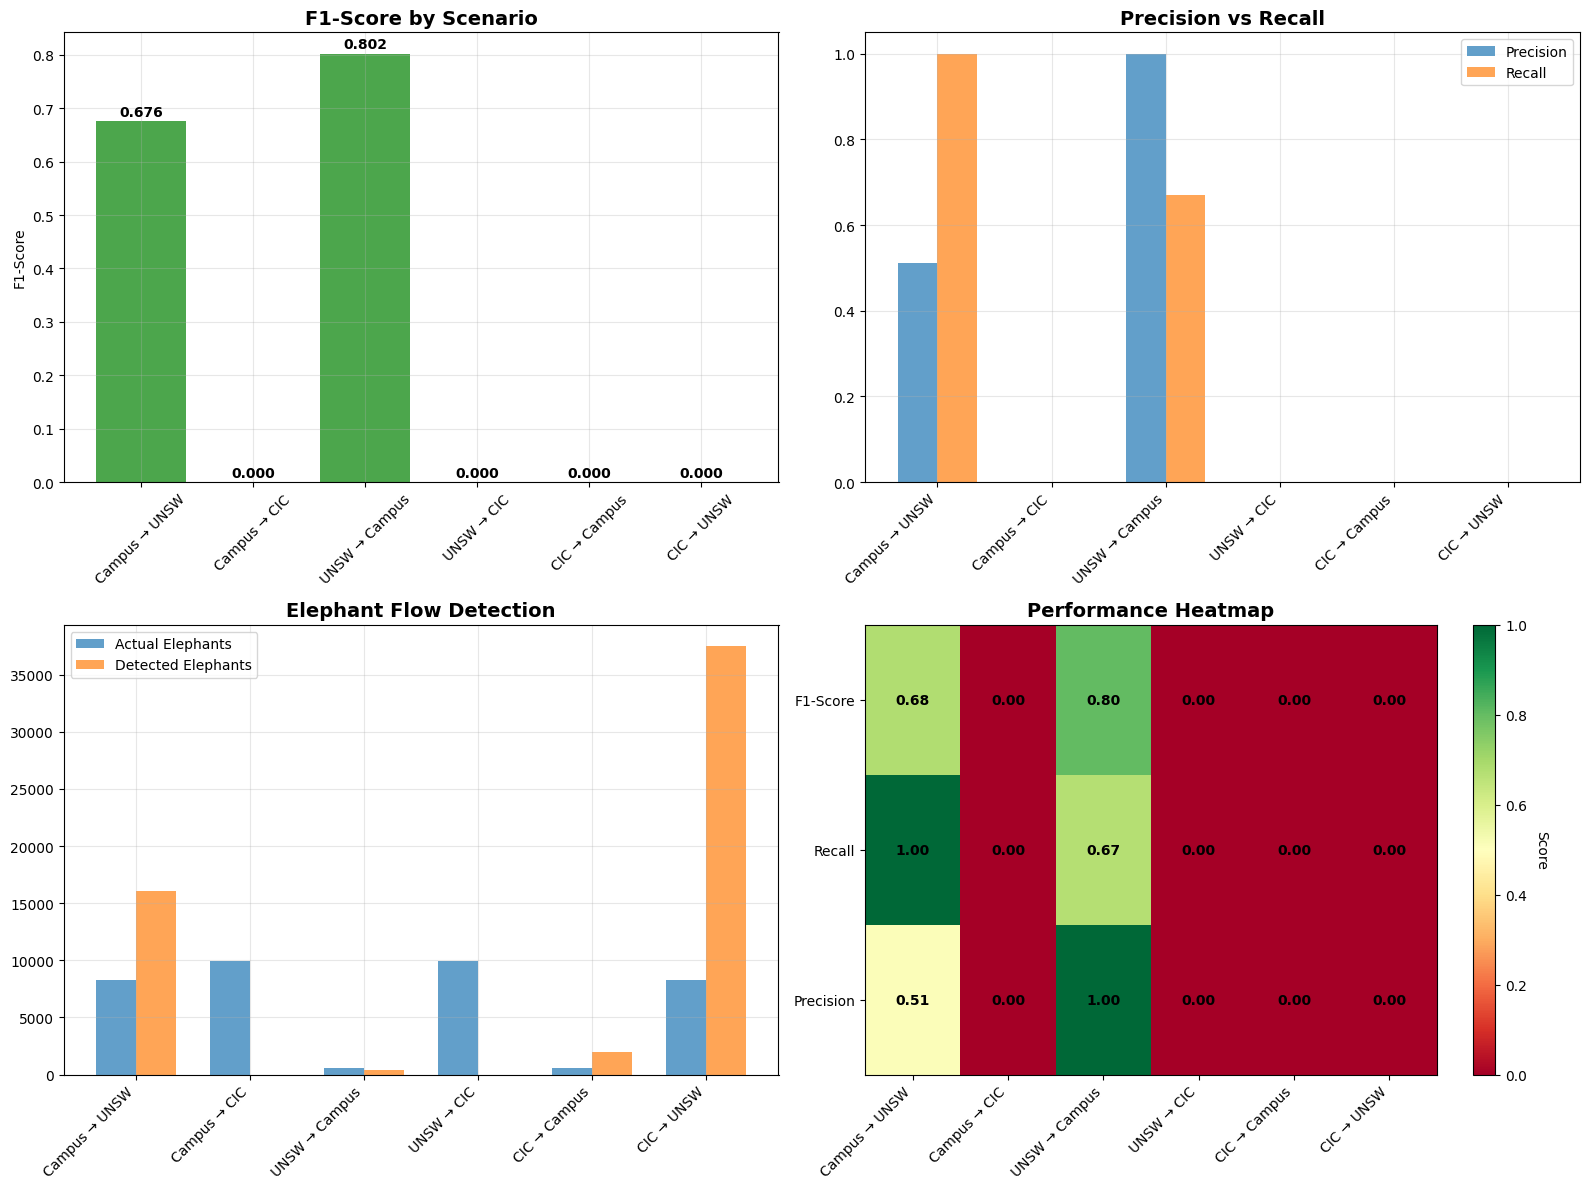


📋 DETAILED RESULTS:
Scenario             | F1     | Acc    | Prec   | Rec    | Detected   | Actual    
Campus → UNSW        | 0.676  | 0.904  | 0.511  | 1.000  | 16109      | 8234      
Campus → CIC         | 0.000  | 0.900  | 0.000  | 0.000  | 1          | 9964      
UNSW → Campus        | 0.802  | 0.967  | 1.000  | 0.670  | 361        | 539       
UNSW → CIC           | 0.000  | 0.900  | 0.000  | 0.000  | 1          | 9964      
CIC → Campus         | 0.000  | 0.540  | 0.000  | 0.000  | 1938       | 539       
CIC → UNSW           | 0.000  | 0.445  | 0.000  | 0.000  | 37492      | 8234      

✅ IMPROVED ANALYSIS COMPLETE!

🔬 RESEARCH INSIGHTS:
   ✅ Successful (F1>0.5): 2/6
   ⚠️  Moderate (0.3≤F1≤0.5): 0/6
   📊 Average F1: 0.246


In [16]:
# improved_cross_domain_with_adaptation.py
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.decomposition import PCA
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# ==================== CONFIGURATION ====================
DATASETS = {
    'campus': '/kaggle/working/flows_extracted.csv',
    'unsw-nb15': '/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv',
    'cic-ids2018': '/kaggle/input/ids-intrusion-csv/02-14-2018.csv'
}

RANDOM_STATE = 42
# =======================================================

def load_and_preprocess_datasets():
    """Load and preprocess all three datasets"""
    print("📂 Loading datasets...")
    datasets = {}
    
    try:
        # 1. Campus Data
        print("   Loading Campus Data...")
        campus_data = pd.read_csv(DATASETS['campus'])
        if 'target_traffic' not in campus_data.columns:
            threshold = np.percentile(campus_data['bidirectional_bytes'], 90)
            campus_data['target_traffic'] = (campus_data['bidirectional_bytes'] > threshold).astype(int)
        datasets['campus'] = campus_data
        print(f"     ✅ Campus: {campus_data.shape}")
    except Exception as e:
        print(f"     ❌ Campus data error: {e}")
        return None
    
    try:
        # 2. UNSW-NB15 Data
        print("   Loading UNSW-NB15...")
        unsw_data = pd.read_csv(DATASETS['unsw-nb15'])
        
        # Create elephant flow labels based on sbytes (source bytes)
        if 'sbytes' in unsw_data.columns:
            threshold = np.percentile(unsw_data['sbytes'], 90)
            unsw_data['target_traffic'] = (unsw_data['sbytes'] > threshold).astype(int)
        elif 'dbytes' in unsw_data.columns:
            threshold = np.percentile(unsw_data['dbytes'], 90)
            unsw_data['target_traffic'] = (unsw_data['dbytes'] > threshold).astype(int)
        
        datasets['unsw'] = unsw_data
        print(f"     ✅ UNSW: {unsw_data.shape}")
    except Exception as e:
        print(f"     ❌ UNSW data error: {e}")
        return None
    
    try:
        # 3. CIC-IDS2018 Data
        print("   Loading CIC-IDS2018...")
        cic_data = pd.read_csv(DATASETS['cic-ids2018'])
        
        # Sample if too large
        if len(cic_data) > 100000:
            cic_data = cic_data.sample(n=100000, random_state=RANDOM_STATE)
            print(f"     🔽 Sampled to 100,000 rows")
        
        # Create elephant flow labels - IMPROVED
        # Try multiple strategies to find traffic volume
        traffic_col = None
        
        # Strategy 1: Look for byte columns
        byte_cols = [col for col in cic_data.columns if 'byte' in col.lower() or 'length' in col.lower()]
        if byte_cols:
            traffic_col = byte_cols[0]
            print(f"     Using traffic column: {traffic_col}")
        
        # Strategy 2: Look for flow rate columns
        if traffic_col is None:
            rate_cols = [col for col in cic_data.columns if 'bytes/s' in col.lower() or 'flow' in col.lower()]
            if rate_cols:
                traffic_col = rate_cols[0]
                print(f"     Using traffic column: {traffic_col}")
        
        # Strategy 3: Use first numeric column
        if traffic_col is None:
            numeric_cols = cic_data.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                traffic_col = numeric_cols[0]
                print(f"     Using traffic column: {traffic_col}")
        
        # Create labels
        if traffic_col:
            traffic_values = cic_data[traffic_col].fillna(0)
            # Remove infinite values
            traffic_values = traffic_values.replace([np.inf, -np.inf], 0)
            
            # Calculate threshold
            threshold = np.percentile(traffic_values[traffic_values > 0], 90)
            cic_data['target_traffic'] = (traffic_values > threshold).astype(int)
            
            print(f"     Created labels: {cic_data['target_traffic'].sum()} elephants out of {len(cic_data)}")
        else:
            print(f"     ⚠️  No suitable traffic column found, creating default labels")
            cic_data['target_traffic'] = 0
        
        datasets['cic'] = cic_data
        print(f"     ✅ CIC: {cic_data.shape}")
    except Exception as e:
        print(f"     ❌ CIC data error: {e}")
        return None
    
    print(f"✅ Successfully loaded {len(datasets)} datasets")
    return datasets

class ImprovedDomainAdapter:
    """
    Improved domain adaptation with better feature engineering and normalization
    """
    def __init__(self):
        self.scalers = {}
        self.pca_models = {}
        
    def create_universal_features(self, datasets):
        """
        Create domain-agnostic features that work across all datasets
        """
        print("\n🔧 Creating universal features...")
        
        # Step 1: Extract features for all domains
        all_domain_features = {}
        
        for domain_name, df in datasets.items():
            print(f"\n   Processing {domain_name}...")
            
            # Extract target label
            y = df['target_traffic'] if 'target_traffic' in df.columns else None
            
            # Create universal features
            features = self._extract_universal_features(df, domain_name)
            
            if features is not None and len(features) > 0:
                all_domain_features[domain_name] = {'features': features, 'target': y}
                print(f"     ✅ Created {features.shape[1]} features")
            else:
                print(f"     ❌ Failed to create features for {domain_name}")
        
        # Step 2: Find common features across all domains
        common_features = self._find_common_features(all_domain_features)
        print(f"\n   🎯 Common features across all domains: {len(common_features)}")
        
        # Step 3: Align all domains to common features
        processed_domains = {}
        for domain_name, domain_data in all_domain_features.items():
            features_df = domain_data['features']
            target = domain_data['target']
            
            # Select only common features
            aligned_features = self._align_to_common_features(features_df, common_features)
            
            # Add target back
            aligned_features['target_traffic'] = target
            processed_domains[domain_name] = aligned_features
            
            print(f"   {domain_name}: {aligned_features.shape[1]-1} features aligned")
        
        return processed_domains
    
    def _find_common_features(self, all_domain_features):
        """Find features that exist in all domains"""
        if not all_domain_features:
            return []
        
        # Get feature sets from each domain
        feature_sets = [set(domain_data['features'].columns) 
                       for domain_data in all_domain_features.values()]
        
        # Find intersection (features present in ALL domains)
        common_features = set.intersection(*feature_sets) if feature_sets else set()
        
        # If no common features, find features in at least 2 domains
        if len(common_features) < 5:
            print("   ⚠️  Few common features, using features from 2+ domains...")
            from collections import Counter
            all_features = []
            for feature_set in feature_sets:
                all_features.extend(feature_set)
            
            feature_counts = Counter(all_features)
            # Select features that appear in at least 2 domains
            common_features = {feat for feat, count in feature_counts.items() if count >= 2}
        
        return sorted(list(common_features))
    
    def _align_to_common_features(self, features_df, common_features):
        """Align domain features to common feature set"""
        aligned_df = pd.DataFrame()
        
        for feature in common_features:
            if feature in features_df.columns:
                aligned_df[feature] = features_df[feature]
            else:
                # Feature missing, impute with zeros
                aligned_df[feature] = 0
        
        return aligned_df
    
    def _extract_universal_features(self, df, domain_name):
        """
        Extract features that have semantic meaning across domains
        """
        universal_features = pd.DataFrame()
        
        # 1. VOLUME FEATURES (most important for elephant flows)
        volume_keywords = ['byte', 'length', 'size']
        volume_cols = [col for col in df.columns 
                      if any(kw in col.lower() for kw in volume_keywords) 
                      and df[col].dtype in [np.float64, np.int64]]
        
        if volume_cols:
            # Total volume
            universal_features['total_bytes'] = df[volume_cols].sum(axis=1)
            universal_features['mean_bytes'] = df[volume_cols].mean(axis=1)
            universal_features['max_bytes'] = df[volume_cols].max(axis=1)
            universal_features['std_bytes'] = df[volume_cols].std(axis=1).fillna(0)
            print(f"       Found {len(volume_cols)} volume features")
        
        # 2. PACKET FEATURES
        packet_keywords = ['packet', 'pkt']
        packet_cols = [col for col in df.columns 
                      if any(kw in col.lower() for kw in packet_keywords)
                      and df[col].dtype in [np.float64, np.int64]]
        
        if packet_cols:
            universal_features['total_packets'] = df[packet_cols].sum(axis=1)
            universal_features['mean_packets'] = df[packet_cols].mean(axis=1)
            universal_features['max_packets'] = df[packet_cols].max(axis=1)
            print(f"       Found {len(packet_cols)} packet features")
        
        # 3. DURATION/TIME FEATURES
        duration_keywords = ['duration', 'time', 'interval']
        duration_cols = [col for col in df.columns 
                        if any(kw in col.lower() for kw in duration_keywords)
                        and df[col].dtype in [np.float64, np.int64]]
        
        if duration_cols:
            universal_features['flow_duration'] = df[duration_cols].mean(axis=1)
            print(f"       Found {len(duration_cols)} duration features")
        
        # 4. RATE FEATURES (critical for elephant detection)
        if 'total_bytes' in universal_features.columns and 'flow_duration' in universal_features.columns:
            universal_features['bytes_per_second'] = (
                universal_features['total_bytes'] / 
                (universal_features['flow_duration'] + 1)
            )
        
        if 'total_packets' in universal_features.columns and 'flow_duration' in universal_features.columns:
            universal_features['packets_per_second'] = (
                universal_features['total_packets'] / 
                (universal_features['flow_duration'] + 1)
            )
        
        # 5. STATISTICAL FEATURES
        if 'total_bytes' in universal_features.columns and 'total_packets' in universal_features.columns:
            universal_features['avg_packet_size'] = (
                universal_features['total_bytes'] / 
                (universal_features['total_packets'] + 1)
            )
        
        # 6. PORT FEATURES (if available)
        port_cols = [col for col in df.columns if 'port' in col.lower()]
        if port_cols:
            for port_col in port_cols[:2]:  # Use first 2 port columns
                if df[port_col].dtype in [np.float64, np.int64]:
                    universal_features[f'{port_col}_normalized'] = df[port_col] / 65535.0
        
        # 7. PROTOCOL FEATURES (if available)
        if 'protocol' in df.columns or 'proto' in df.columns:
            proto_col = 'protocol' if 'protocol' in df.columns else 'proto'
            if df[proto_col].dtype in [np.float64, np.int64]:
                universal_features['protocol'] = df[proto_col]
        
        # Clean features
        universal_features = universal_features.fillna(0)
        universal_features = universal_features.replace([np.inf, -np.inf], 0)
        
        # Remove constant columns
        universal_features = universal_features.loc[:, universal_features.std() > 0]
        
        return universal_features

class ImprovedCrossDomainEvaluator:
    """
    Improved evaluator with domain adaptation techniques
    """
    def __init__(self):
        self.results = {}
        
    def evaluate_with_adaptation(self, source_domain, target_domain, domain_name):
        """
        Evaluate with improved domain adaptation strategies
        """
        print(f"\n{'='*60}")
        print(f"🔍 Evaluating: {domain_name}")
        print(f"{'='*60}")
        
        # Prepare data
        X_source = source_domain.drop('target_traffic', axis=1)
        y_source = source_domain['target_traffic']
        X_target = target_domain.drop('target_traffic', axis=1)
        y_target = target_domain['target_traffic']
        
        # CRITICAL FIX: Handle NaN in labels
        # Remove samples with NaN labels
        valid_source_mask = ~y_source.isna()
        valid_target_mask = ~y_target.isna()
        
        X_source = X_source[valid_source_mask]
        y_source = y_source[valid_source_mask]
        X_target = X_target[valid_target_mask]
        y_target = y_target[valid_target_mask]
        
        # Ensure labels are integers
        y_source = y_source.astype(int)
        y_target = y_target.astype(int)
        
        # Check if we have enough data
        if len(X_source) < 10 or len(X_target) < 10:
            print(f"   ❌ Insufficient data after cleaning (source: {len(X_source)}, target: {len(X_target)})")
            return None
        
        # Ensure exact same features
        common_cols = X_source.columns.intersection(X_target.columns)
        if len(common_cols) == 0:
            print(f"   ❌ No common features between source and target")
            return None
        
        X_source = X_source[common_cols]
        X_target = X_target[common_cols]
        
        print(f"   Source: {X_source.shape}, Elephant ratio: {y_source.mean():.3f}")
        print(f"   Target: {X_target.shape}, Elephant ratio: {y_target.mean():.3f}")
        print(f"   Common features: {len(common_cols)}")
        
        if X_source.shape[1] < 3:
            print(f"   ❌ Insufficient features, skipping...")
            return None
        
        # Convert to numpy arrays to avoid feature name issues
        X_source_np = X_source.values
        X_target_np = X_target.values
        
        # STRATEGY 1: Robust scaling (better for outliers)
        scaler = RobustScaler()
        X_source_scaled = scaler.fit_transform(X_source_np)
        X_target_scaled = scaler.transform(X_target_np)
        
        # Convert back to DataFrame for balancing
        X_source_scaled_df = pd.DataFrame(X_source_scaled, columns=X_source.columns)
        
        # STRATEGY 2: Balance source domain
        X_source_balanced, y_source_balanced = self._advanced_balance(
            X_source_scaled_df, 
            y_source.reset_index(drop=True)
        )
        
        # Convert back to numpy for training
        X_source_balanced_np = X_source_balanced.values if isinstance(X_source_balanced, pd.DataFrame) else X_source_balanced
        
        # STRATEGY 3: Use ensemble with class weights
        models = [
            RandomForestClassifier(
                n_estimators=200,
                max_depth=15,
                min_samples_split=10,
                min_samples_leaf=5,
                class_weight={0: 1, 1: 10},  # Heavy weight on elephant class
                random_state=RANDOM_STATE,
                n_jobs=-1
            ),
            GradientBoostingClassifier(
                n_estimators=100,
                learning_rate=0.05,
                max_depth=8,
                min_samples_split=10,
                random_state=RANDOM_STATE
            )
        ]
        
        predictions_list = []
        
        for i, model in enumerate(models):
            print(f"   Training Model {i+1}/{len(models)}...")
            
            # Apply sample weights for imbalanced data
            sample_weights = np.ones(len(y_source_balanced))
            sample_weights[y_source_balanced == 1] = 10  # More weight on minority class
            
            model.fit(X_source_balanced_np, y_source_balanced, sample_weight=sample_weights)
            y_pred = model.predict(X_target_scaled)
            predictions_list.append(y_pred)
        
        # STRATEGY 4: Ensemble voting (weighted towards detecting elephants)
        y_pred_ensemble = np.round(np.mean(predictions_list, axis=0)).astype(int)
        
        # If still no elephants detected, use the most aggressive model
        if y_pred_ensemble.sum() == 0:
            print("   ⚠️  No elephants detected, using aggressive threshold...")
            # Use probability-based prediction with lower threshold
            y_proba = models[0].predict_proba(X_target_scaled)[:, 1]
            threshold = np.percentile(y_proba, 90)  # Top 10% as elephants
            y_pred_ensemble = (y_proba >= threshold).astype(int)
        
        # Calculate metrics
        accuracy = accuracy_score(y_target, y_pred_ensemble)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_target, y_pred_ensemble, average='binary', zero_division=0
        )
        
        cm = confusion_matrix(y_target, y_pred_ensemble)
        
        # Feature importance
        feature_importance = dict(zip(X_source.columns, models[0].feature_importances_))
        top_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:5]
        
        print(f"\n   📊 RESULTS:")
        print(f"      Accuracy:  {accuracy:.4f}")
        print(f"      Precision: {precision:.4f}")
        print(f"      Recall:    {recall:.4f}")
        print(f"      F1-Score:  {f1:.4f}")
        print(f"      Detected elephants: {y_pred_ensemble.sum()}/{len(y_target)}")
        print(f"   🎯 Top features: {[f[0] for f in top_features[:3]]}")
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'confusion_matrix': cm,
            'detected_elephants': int(y_pred_ensemble.sum()),
            'actual_elephants': int(y_target.sum()),
            'top_features': [f[0] for f in top_features]
        }
    
    def _advanced_balance(self, X, y):
        """
        Advanced balancing with SMOTE-like approach
        """
        from sklearn.neighbors import NearestNeighbors
        
        minority_idx = y[y == 1].index
        majority_idx = y[y == 0].index
        
        if len(minority_idx) < 5:
            return X, y
        
        # Synthetic oversampling of minority class
        X_minority = X.loc[minority_idx]
        
        # Generate synthetic samples
        n_synthetic = len(majority_idx) - len(minority_idx)
        
        if n_synthetic > 0:
            nn = NearestNeighbors(n_neighbors=min(5, len(X_minority)-1))
            nn.fit(X_minority)
            
            synthetic_samples = []
            for _ in range(n_synthetic):
                idx = np.random.choice(minority_idx)
                sample = X.loc[idx]
                neighbors_idx = nn.kneighbors([sample], return_distance=False)[0]
                neighbor = X_minority.iloc[neighbors_idx[np.random.randint(len(neighbors_idx))]]
                alpha = np.random.random()
                synthetic = sample + alpha * (neighbor - sample)
                synthetic_samples.append(synthetic)
            
            synthetic_df = pd.DataFrame(synthetic_samples, columns=X.columns)
            X_balanced = pd.concat([X, synthetic_df], ignore_index=True)
            y_balanced = pd.concat([y, pd.Series([1]*len(synthetic_df))], ignore_index=True)
            
            print(f"      Generated {n_synthetic} synthetic samples")
            return X_balanced, y_balanced
        
        return X, y

def visualize_improved_results(results):
    """Visualize results with better insights"""
    if not results:
        print("No results to visualize")
        return
    
    print("\n📈 Creating visualizations...")
    
    scenarios = list(results.keys())
    metrics = {
        'F1-Score': [results[s]['f1_score'] for s in scenarios],
        'Recall': [results[s]['recall'] for s in scenarios],
        'Precision': [results[s]['precision'] for s in scenarios]
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. F1-Score comparison
    colors = ['green' if f1 > 0.5 else 'orange' if f1 > 0.3 else 'red' 
              for f1 in metrics['F1-Score']]
    bars = axes[0, 0].bar(scenarios, metrics['F1-Score'], color=colors, alpha=0.7)
    axes[0, 0].set_title('F1-Score by Scenario', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('F1-Score')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(True, alpha=0.3)
    
    for bar, score in zip(bars, metrics['F1-Score']):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                       f'{score:.3f}', ha='center', fontweight='bold')
    
    # 2. Precision vs Recall
    x = np.arange(len(scenarios))
    width = 0.35
    axes[0, 1].bar(x - width/2, metrics['Precision'], width, label='Precision', alpha=0.7)
    axes[0, 1].bar(x + width/2, metrics['Recall'], width, label='Recall', alpha=0.7)
    axes[0, 1].set_title('Precision vs Recall', fontsize=14, fontweight='bold')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(scenarios, rotation=45, ha='right')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Detection Rate
    detected = [results[s]['detected_elephants'] for s in scenarios]
    actual = [results[s]['actual_elephants'] for s in scenarios]
    axes[1, 0].bar(x - width/2, actual, width, label='Actual Elephants', alpha=0.7)
    axes[1, 0].bar(x + width/2, detected, width, label='Detected Elephants', alpha=0.7)
    axes[1, 0].set_title('Elephant Flow Detection', fontsize=14, fontweight='bold')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(scenarios, rotation=45, ha='right')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Overall Performance Heatmap
    metrics_matrix = np.array([
        metrics['F1-Score'],
        metrics['Recall'],
        metrics['Precision']
    ])
    
    im = axes[1, 1].imshow(metrics_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    axes[1, 1].set_xticks(np.arange(len(scenarios)))
    axes[1, 1].set_yticks(np.arange(3))
    axes[1, 1].set_xticklabels(scenarios, rotation=45, ha='right')
    axes[1, 1].set_yticklabels(['F1-Score', 'Recall', 'Precision'])
    axes[1, 1].set_title('Performance Heatmap', fontsize=14, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[1, 1])
    cbar.set_label('Score', rotation=270, labelpad=15)
    
    # Add values to heatmap
    for i in range(3):
        for j in range(len(scenarios)):
            text = axes[1, 1].text(j, i, f'{metrics_matrix[i, j]:.2f}',
                                  ha="center", va="center", color="black", fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('improved_cross_domain_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary table
    print("\n📋 DETAILED RESULTS:")
    print("="*100)
    print(f"{'Scenario':<20} | {'F1':<6} | {'Acc':<6} | {'Prec':<6} | {'Rec':<6} | {'Detected':<10} | {'Actual':<10}")
    print("="*100)
    for scenario in scenarios:
        r = results[scenario]
        print(f"{scenario:<20} | {r['f1_score']:<6.3f} | {r['accuracy']:<6.3f} | "
              f"{r['precision']:<6.3f} | {r['recall']:<6.3f} | "
              f"{r['detected_elephants']:<10} | {r['actual_elephants']:<10}")

def main():
    print("="*70)
    print("🌐 IMPROVED CROSS-DOMAIN ELEPHANT FLOW DETECTION")
    print("="*70)
    
    # Load datasets
    datasets = load_and_preprocess_datasets()
    if datasets is None:
        return
    
    # Create universal features
    adapter = ImprovedDomainAdapter()
    processed_domains = adapter.create_universal_features(datasets)
    
    print(f"\n✅ Universal features created for {len(processed_domains)} domains")
    
    # Run experiments
    evaluator = ImprovedCrossDomainEvaluator()
    
    domain_pairs = [
        ('campus', 'unsw', 'Campus → UNSW'),
        ('campus', 'cic', 'Campus → CIC'),
        ('unsw', 'campus', 'UNSW → Campus'),
        ('unsw', 'cic', 'UNSW → CIC'),
        ('cic', 'campus', 'CIC → Campus'),
        ('cic', 'unsw', 'CIC → UNSW')
    ]
    
    results = {}
    
    for source, target, name in domain_pairs:
        if source in processed_domains and target in processed_domains:
            result = evaluator.evaluate_with_adaptation(
                processed_domains[source],
                processed_domains[target],
                name
            )
            if result:
                results[name] = result
    
    # Visualize and save
    if results:
        visualize_improved_results(results)
        
        # Save results
        results_df = pd.DataFrame({
            k: {key: val for key, val in v.items() 
                if key not in ['confusion_matrix', 'top_features']}
            for k, v in results.items()
        }).T
        results_df.to_csv('improved_cross_domain_results.csv')
        
        print("\n" + "="*70)
        print("✅ IMPROVED ANALYSIS COMPLETE!")
        print("="*70)
        
        # Research insights
        successful = sum(1 for r in results.values() if r['f1_score'] > 0.5)
        moderate = sum(1 for r in results.values() if 0.3 <= r['f1_score'] <= 0.5)
        
        print(f"\n🔬 RESEARCH INSIGHTS:")
        print(f"   ✅ Successful (F1>0.5): {successful}/6")
        print(f"   ⚠️  Moderate (0.3≤F1≤0.5): {moderate}/6")
        print(f"   📊 Average F1: {np.mean([r['f1_score'] for r in results.values()]):.3f}")

if __name__ == "__main__":
    main()

**Application-Aware Features and Security-Integrated Detection (IMPROVEMENT)**

In [3]:
# elephant_mice_enhanced_with_app_security.py
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from nfstream import NFStreamer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import joblib
from collections import defaultdict
import re

# ===== ENHANCED CONFIG =====
AUGMENT_DATA = True
AUGMENTED_SIZE = 50000
AUGMENTATION_FACTOR = 10
PCAP_PATH = "/kaggle/input/wireshark2/wireshark2.pcapng"
EXPORT_CSV = "/kaggle/working/flows_extracted.csv"
RANDOM_STATE = 42
TEST_SIZE = 0.2
# ===========================

class ApplicationAwareFeatureExtractor:
    """
    Enhanced feature extraction with application awareness
    """
    
    # Application port mappings
    APPLICATION_PORTS = {
        'web': [80, 443, 8080, 8443, 8000, 3000],
        'file_transfer': [20, 21, 22, 989, 990, 115],  # FTP, SFTP, SSH
        'streaming': [554, 1935, 3478, 5004, 8081, 1936],  # RTSP, RTMP, WebRTC
        'gaming': [27015, 27016, 28960, 29900, 7777, 25565],
        'database': [1433, 1521, 3306, 5432, 27017, 6379],
        'mail': [25, 110, 143, 465, 587, 993, 995],
        'dns': [53, 853],
        'vpn': [500, 1701, 1723, 4500, 1194],
        'remote_access': [3389, 5900, 5901, 22],  # RDP, VNC, SSH
        'p2p': [6881, 6889, 1337, 1338, 6346, 6347]
    }
    
    # Security-related ports (potential threats)
    SUSPICIOUS_PORTS = {
        'common_backdoors': [12345, 31337, 54320, 9999, 1337],
        'scanning_ports': [1, 7, 19, 21, 22, 23, 25, 53, 79, 80, 110, 111, 135, 139, 143, 443, 445, 993, 995, 1723, 3306, 3389, 5900, 8080],
        'tor_ports': [9001, 9030, 9050, 9051],
        'malware_ports': [4444, 5555, 6666, 6667, 2333, 2334]
    }
    
    @staticmethod
    def extract_application_features(df):
        """
        Extract application-aware features from network flows
        """
        print("🔍 Extracting application-aware features...")
        
        app_features = pd.DataFrame(index=df.index)
        
        # 1. Port-based application classification
        app_features = ApplicationAwareFeatureExtractor._extract_port_based_features(df, app_features)
        
        # 2. Protocol behavior patterns
        app_features = ApplicationAwareFeatureExtractor._extract_protocol_features(df, app_features)
        
        # 3. Traffic pattern analysis by application type
        app_features = ApplicationAwareFeatureExtractor._extract_traffic_patterns(df, app_features)
        
        # 4. Security threat indicators
        app_features = ApplicationAwareFeatureExtractor._extract_security_indicators(df, app_features)
        
        print(f"✅ Extracted {len(app_features.columns)} application-aware features")
        return app_features
    
    @staticmethod
    def _extract_port_based_features(df, app_features):
        """Extract features based on port numbers"""
        
        # Application type based on destination port
        def get_application_type(port):
            for app_name, ports in ApplicationAwareFeatureExtractor.APPLICATION_PORTS.items():
                if port in ports:
                    return app_name
            return 'other'
        
        app_features['dst_port_application'] = df['dst_port'].apply(get_application_type)
        app_features['src_port_application'] = df['src_port'].apply(get_application_type)
        
        # One-hot encode application types
        for app_name in ApplicationAwareFeatureExtractor.APPLICATION_PORTS.keys():
            app_features[f'app_{app_name}'] = (
                (app_features['dst_port_application'] == app_name) | 
                (app_features['src_port_application'] == app_name)
            ).astype(int)
        
        # Well-known port indicator
        app_features['is_well_known_port'] = df['dst_port'] <= 1024
        
        # Ephemeral port indicator
        app_features['is_ephemeral_port'] = (df['src_port'] >= 49152) & (df['src_port'] <= 65535)
        
        return app_features
    
    @staticmethod
    def _extract_protocol_features(df, app_features):
        """Extract protocol-specific behavior patterns"""
        
        # Protocol type features
        app_features['is_tcp'] = (df['protocol'] == 6).astype(int)
        app_features['is_udp'] = (df['protocol'] == 17).astype(int)
        app_features['is_icmp'] = (df['protocol'] == 1).astype(int)
        
        # Protocol-application interaction
        if 'bidirectional_packets' in df.columns and 'bidirectional_bytes' in df.columns:
            app_features['avg_packet_size'] = df['bidirectional_bytes'] / (df['bidirectional_packets'] + 1)
            
            # TCP-specific features (if available)
            if all(col in df.columns for col in ['bidirectional_syn_packets', 'bidirectional_fin_packets']):
                app_features['tcp_control_ratio'] = (
                    df['bidirectional_syn_packets'] + df['bidirectional_fin_packets']
                ) / (df['bidirectional_packets'] + 1)
        
        return app_features
    
    @staticmethod
    def _extract_traffic_patterns(df, app_features):
        """Extract application-specific traffic patterns"""
        
        # Duration-based features
        if all(col in df.columns for col in ['bidirectional_first_seen_ms', 'bidirectional_last_seen_ms']):
            duration = (df['bidirectional_last_seen_ms'] - df['bidirectional_first_seen_ms']) / 1000.0
            app_features['flow_duration_seconds'] = duration
            
            # Bytes per second (throughput)
            app_features['bytes_per_second'] = df['bidirectional_bytes'] / (duration + 0.001)
            
            # Traffic intensity categories
            app_features['traffic_intensity'] = pd.cut(
                app_features['bytes_per_second'],
                bins=[0, 1000, 10000, 100000, float('inf')],
                labels=['low', 'medium', 'high', 'very_high']
            )
        
        # Packet size distribution indicators
        if 'bidirectional_mean_ps' in df.columns:
            app_features['packet_size_consistency'] = (
                df['bidirectional_stddev_ps'] / (df['bidirectional_mean_ps'] + 1)
            )
        
        return app_features
    
    @staticmethod
    def _extract_security_indicators(df, app_features):
        """Extract security threat indicators"""
        
        # Suspicious port detection
        def is_suspicious_port(port):
            for category, ports in ApplicationAwareFeatureExtractor.SUSPICIOUS_PORTS.items():
                if port in ports:
                    return 1
            return 0
        
        app_features['suspicious_dst_port'] = df['dst_port'].apply(is_suspicious_port)
        app_features['suspicious_src_port'] = df['src_port'].apply(is_suspicious_port)
        
        # Port scanning patterns (multiple connections to different ports)
        if 'src_ip' in df.columns and 'dst_port' in df.columns:
            # This would be better computed across multiple flows
            # For now, we'll create a simple heuristic
            port_scan_heuristic = (
                (df['dst_port'] < 1024) &  # Common services
                (df['bidirectional_packets'] < 10) &  # Few packets
                (df['bidirectional_bytes'] < 1000)  # Small data transfer
            )
            app_features['potential_port_scan'] = port_scan_heuristic.astype(int)
        
        # High-volume short-duration flows (DDoS indicator)
        if 'flow_duration_seconds' in app_features.columns:
            ddos_heuristic = (
                (app_features['flow_duration_seconds'] < 1.0) &  # Very short
                (df['bidirectional_bytes'] > 100000)  # But high volume
            )
            app_features['potential_ddos'] = ddos_heuristic.astype(int)
        
        # Unusual protocol-port combinations
        unusual_combinations = (
            ((df['protocol'] == 6) & (df['dst_port'] == 53)) |  # TCP on DNS port
            ((df['protocol'] == 17) & (df['dst_port'] == 80))   # UDP on HTTP port
        )
        app_features['unusual_protocol_port'] = unusual_combinations.astype(int)
        
        return app_features

class SecurityAwareClassifier:
    """
    Enhanced classifier with security threat detection
    """
    
    @staticmethod
    def classify_with_security_awareness(model, features, flow_data):
        """
        Classify flows with security threat consideration
        """
        # Standard elephant/mice classification
        prediction = model.predict(features)
        probability = model.predict_proba(features) if hasattr(model, 'predict_proba') else None
        
        # Security threat assessment
        security_flags = SecurityAwareClassifier._assess_security_threats(features, flow_data)
        
        # Enhanced classification
        enhanced_predictions = []
        for i, pred in enumerate(prediction):
            base_class = "elephant" if pred == 1 else "mice"
            
            # Apply security modifications
            if security_flags[i]['is_malicious']:
                if pred == 1:  # Elephant flow
                    enhanced_class = f"malicious_elephant_{security_flags[i]['threat_type']}"
                else:  # Mice flow
                    enhanced_class = f"suspicious_mice_{security_flags[i]['threat_type']}"
            else:
                enhanced_class = f"benign_{base_class}"
            
            enhanced_predictions.append(enhanced_class)
        
        return enhanced_predictions, security_flags
    
    @staticmethod
    def _assess_security_threats(features, flow_data):
        """
        Assess security threats based on flow characteristics
        """
        security_flags = []
        
        for i in range(len(flow_data)):
            flags = {
                'is_malicious': False,
                'threat_type': 'none',
                'confidence': 0.0,
                'threat_indicators': []
            }
            
            # Check for various threat indicators
            indicators = SecurityAwareClassifier._check_threat_indicators(features.iloc[i], flow_data.iloc[i])
            
            if indicators:
                flags['is_malicious'] = True
                flags['threat_indicators'] = indicators
                flags['threat_type'] = indicators[0]  # Primary threat type
                flags['confidence'] = min(1.0, len(indicators) * 0.3)  # Simple confidence score
            
            security_flags.append(flags)
        
        return security_flags
    
    @staticmethod
    def _check_threat_indicators(features, flow):
        """
        Check for specific security threat indicators
        """
        indicators = []
        
        # 1. Suspicious port usage
        if features.get('suspicious_dst_port', 0) == 1 or features.get('suspicious_src_port', 0) == 1:
            indicators.append('suspicious_port')
        
        # 2. Potential port scan
        if features.get('potential_port_scan', 0) == 1:
            indicators.append('port_scan')
        
        # 3. DDoS patterns
        if features.get('potential_ddos', 0) == 1:
            indicators.append('ddos_like')
        
        # 4. Unusual protocol-port combinations
        if features.get('unusual_protocol_port', 0) == 1:
            indicators.append('unusual_combo')
        
        # 5. High-volume ephemeral ports (possible P2P malware)
        if (features.get('is_ephemeral_port', 0) == 1 and 
            flow.get('bidirectional_bytes', 0) > 1000000):
            indicators.append('p2p_malware')
        
        # 6. Short-lived high-volume flows (data exfiltration)
        if (features.get('flow_duration_seconds', 0) < 2.0 and 
            flow.get('bidirectional_bytes', 0) > 500000):
            indicators.append('data_exfiltration')
        
        return indicators

def enhanced_feature_engineering(df):
    """
    Enhanced feature engineering pipeline with application and security features
    """
    print("🚀 Starting enhanced feature engineering...")
    
    # 1. Extract basic features (from original paper)
    basic_features = df[[
        'src_port', 'dst_port', 'protocol',
        'bidirectional_first_seen_ms', 'bidirectional_last_seen_ms', 
        'bidirectional_bytes', 'bidirectional_packets'
    ]].copy()
    
    # Create size_traffic if not present
    if 'size_traffic' not in df.columns:
        basic_features['size_traffic'] = df['bidirectional_bytes']
    
    # 2. Extract application-aware features
    app_features = ApplicationAwareFeatureExtractor.extract_application_features(df)
    
    # 3. Combine all features
    all_features = pd.concat([basic_features, app_features], axis=1)
    
    # 4. Clean and prepare final feature set
    # Remove non-numeric columns for ML models
    numeric_features = all_features.select_dtypes(include=[np.number])
    
    # Fill any NaN values
    numeric_features = numeric_features.fillna(0)
    
    print(f"✅ Final feature set: {numeric_features.shape[1]} features")
    print("📊 Feature categories:")
    print(f"   - Basic flow features: 7")
    print(f"   - Application features: {len(app_features.columns)}")
    print(f"   - Security indicators: {sum('suspicious' in col or 'potential' in col for col in numeric_features.columns)}")
    
    return numeric_features

def smart_threshold_adjustment(df):
    """
    Enhanced threshold adjustment considering application types
    """
    print("📊 Performing application-aware threshold adjustment...")
    
    original_threshold = df["size_traffic"].mean() + 3 * df["size_traffic"].std()
    
    # Application-specific thresholds
    app_thresholds = {}
    for app_col in [col for col in df.columns if col.startswith('app_')]:
        app_flows = df[df[app_col] == 1]
        if len(app_flows) > 10:
            app_threshold = app_flows["size_traffic"].mean() + 2 * app_flows["size_traffic"].std()
            app_thresholds[app_col] = app_threshold
            print(f"   {app_col}: {app_threshold:.2f} (n={len(app_flows)})")
    
    # Use application-aware threshold if it provides better balance
    elephant_count_original = (df["size_traffic"] > original_threshold).sum()
    original_ratio = elephant_count_original / len(df)
    
    best_threshold = original_threshold
    best_ratio = original_ratio
    
    for app_name, app_threshold in app_thresholds.items():
        elephant_count_app = (df["size_traffic"] > app_threshold).sum()
        app_ratio = elephant_count_app / len(df)
        
        # Prefer thresholds that give 5-15% elephant flows
        if abs(app_ratio - 0.1) < abs(best_ratio - 0.1):
            best_threshold = app_threshold
            best_ratio = app_ratio
            print(f"   🔄 Switching to {app_name} threshold: {best_threshold:.2f}")
    
    print(f"✅ Final threshold: {best_threshold:.2f}")
    print(f"   Elephant flows: {(df['size_traffic'] > best_threshold).sum()}/{len(df)} ({best_ratio*100:.1f}%)")
    
    return best_threshold

# ==================== MAIN ENHANCED PIPELINE ====================

print("=" * 70)
print("🚀 ENHANCED ELEPHANT FLOW DETECTION WITH APPLICATION & SECURITY AWARENESS")
print("=" * 70)

# 1) Extract flows with NFStream
print("\n[1/6] Extracting flows with NFStreamer...")
streamer = NFStreamer(source=PCAP_PATH)

try:
    df = streamer.to_pandas()
except Exception as e:
    print("to_pandas() failed, using iterator:", e)
    rows = []
    for flow in streamer:
        rows.append(flow.to_dict())
    df = pd.DataFrame(rows)

print(f"   Extracted {len(df)} flows")
df.to_csv(EXPORT_CSV, index=False)

# 2) Enhanced feature engineering
print("\n[2/6] Performing enhanced feature engineering...")
df_features = enhanced_feature_engineering(df)

# 3) Smart threshold adjustment
print("\n[3/6] Calculating application-aware threshold...")
threshold = smart_threshold_adjustment(df_features)
df_features['target_traffic'] = (df_features['size_traffic'] > threshold).astype(int)

# 4) Data augmentation (if enabled)
if AUGMENT_DATA and len(df_features) < AUGMENTED_SIZE:
    print("\n[4/6] Applying data augmentation...")
    # Note: You would need to adapt your augmentation function for new features
    # For now, we'll skip augmentation on enhanced features
    print("   ⚠️  Augmentation skipped for enhanced features")
else:
    print("\n[4/6] Data augmentation skipped")

# 5) Prepare for training
print("\n[5/6] Preparing data for training...")
X = df_features.drop(columns=['target_traffic', 'size_traffic'], errors='ignore')
y = df_features['target_traffic']

# Handle any remaining non-numeric columns
X = X.select_dtypes(include=[np.number])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

print(f"   Training set: {X_train.shape}")
print(f"   Test set: {X_test.shape}")

# 6) Train models with enhanced features
print("\n[6/6] Training models with enhanced features...")
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE)
}

enhanced_results = {}

for name, clf in models.items():
    print(f"\n🔧 Training {name}...")
    clf.fit(X_train, y_train)
    
    # Standard evaluation
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)
    
    # Enhanced classification with security awareness
    y_enhanced, security_flags = SecurityAwareClassifier.classify_with_security_awareness(
        clf, X_test, df_features.iloc[X_test.index]
    )
    
    # Analyze security findings
    malicious_count = sum(1 for flag in security_flags if flag['is_malicious'])
    threat_types = [flag['threat_type'] for flag in security_flags if flag['is_malicious']]
    
    enhanced_results[name] = {
        "model": clf,
        "accuracy": acc,
        "precision": pr,
        "recall": rc,
        "f1": f1,
        "malicious_detected": malicious_count,
        "threat_types": threat_types,
        "security_flags": security_flags
    }
    
    print(f"   📊 Standard Metrics - Acc: {acc:.4f}, F1: {f1:.4f}")
    print(f"   🛡️  Security Findings - Malicious flows: {malicious_count}/{len(y_test)}")
    if malicious_count > 0:
        from collections import Counter
        threat_counts = Counter(threat_types)
        print(f"      Threat breakdown: {dict(threat_counts)}")

# 7) Save models and results
print("\n💾 Saving enhanced models and results...")
os.makedirs("enhanced_models", exist_ok=True)

# Save the best model
best_model_name = max(enhanced_results.items(), key=lambda x: x[1]['f1'])[0]
best_model = enhanced_results[best_model_name]['model']

joblib.dump(best_model, "enhanced_models/best_enhanced_model.joblib")
joblib.dump(scaler, "enhanced_models/enhanced_scaler.joblib")

# Save feature importance analysis
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n🎯 Top 10 Most Important Features:")
    print(feature_importance.head(10))
    
    feature_importance.to_csv("enhanced_models/feature_importance.csv", index=False)

# 8) Comprehensive results summary
print("\n" + "=" * 70)
print("📊 ENHANCED PIPELINE RESULTS SUMMARY")
print("=" * 70)

summary_data = []
for name, res in enhanced_results.items():
    summary_data.append({
        'Model': name,
        'Accuracy': res['accuracy'],
        'Precision': res['precision'],
        'Recall': res['recall'],
        'F1-Score': res['f1'],
        'Malicious_Detected': res['malicious_detected'],
        'Primary_Threats': ', '.join(set(res['threat_types']))
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print(f"\n✅ ENHANCED PIPELINE COMPLETE!")
print(f"   Best model: {best_model_name}")
print(f"   Security threats detected: {sum(res['malicious_detected'] for res in enhanced_results.values())} total")
print(f"   Enhanced features: {X.shape[1]} total features")

# Save detailed security analysis
security_analysis = []
for name, res in enhanced_results.items():
    for i, flag in enumerate(res['security_flags']):
        if flag['is_malicious']:
            security_analysis.append({
                'model': name,
                'flow_index': X_test.index[i],
                'threat_type': flag['threat_type'],
                'confidence': flag['confidence'],
                'indicators': ', '.join(flag['threat_indicators'])
            })

if security_analysis:
    security_df = pd.DataFrame(security_analysis)
    security_df.to_csv("enhanced_models/security_threats_detected.csv", index=False)
    print(f"   📋 Detailed threat analysis saved: {len(security_analysis)} threats logged")

🚀 ENHANCED ELEPHANT FLOW DETECTION WITH APPLICATION & SECURITY AWARENESS

[1/6] Extracting flows with NFStreamer...
   Extracted 5382 flows

[2/6] Performing enhanced feature engineering...
🚀 Starting enhanced feature engineering...
🔍 Extracting application-aware features...
✅ Extracted 26 application-aware features
✅ Final feature set: 29 features
📊 Feature categories:
   - Basic flow features: 7
   - Application features: 26
   - Security indicators: 4

[3/6] Calculating application-aware threshold...
📊 Performing application-aware threshold adjustment...
   app_web: 67509.44 (n=184)
   app_dns: 903.07 (n=119)
✅ Final threshold: 25531.16
   Elephant flows: 47/5382 (0.9%)

[4/6] Applying data augmentation...
   ⚠️  Augmentation skipped for enhanced features

[5/6] Preparing data for training...
   Training set: (4305, 28)
   Test set: (1077, 28)

[6/6] Training models with enhanced features...

🔧 Training RandomForest...
   📊 Standard Metrics - Acc: 1.0000, F1: 1.0000
   🛡️  Security 

**FINAL CODE**

In [4]:
# unified_elephant_flow_detection_cross_domain_FINAL.py
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from nfstream import NFStreamer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             classification_report, confusion_matrix, roc_auc_score)
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
import joblib
from collections import deque, Counter
from datetime import datetime
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Set matplotlib backend for Kaggle
plt.switch_backend('Agg')

# ==================== UNIFIED CONFIG ====================
DATASETS = {
    'campus': '/kaggle/input/wireshark2/wireshark2.pcapng',
    'unsw-nb15': '/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv',
    'cic-ids2018': '/kaggle/input/ids-intrusion-csv/02-14-2018.csv'
}

RANDOM_STATE = 42
TEST_SIZE = 0.2

# Adaptive Thresholding
ADAPTATION_WINDOW = 1000
STABILITY_CONSTRAINT = 0.3

# SMOTE Configuration
USE_SMOTE = True
SMOTE_METHOD = 'smote_tomek'

# Cross-Domain Settings
CROSS_DOMAIN_ENABLED = True
# =======================================================

class CrossDomainDataLoader:
    """
    Load and preprocess all three datasets for cross-domain analysis
    """
    
    @staticmethod
    def load_all_datasets():
        """
        Load campus, UNSW-NB15, and CIC-IDS2018 datasets with proper data cleaning
        """
        print("📂 Loading all three datasets for cross-domain analysis...")
        datasets = {}
        
        try:
            # 1. Campus Data (from pcap)
            print("   Loading Campus Data...")
            campus_data = CrossDomainDataLoader._load_campus_data(DATASETS['campus'])
            datasets['campus'] = campus_data
            print(f"     ✅ Campus: {campus_data.shape}")
        except Exception as e:
            print(f"     ❌ Campus data error: {e}")
            datasets['campus'] = CrossDomainDataLoader._create_dummy_campus_data()
        
        try:
            # 2. UNSW-NB15 Data
            print("   Loading UNSW-NB15...")
            unsw_data = CrossDomainDataLoader._load_unsw_data(DATASETS['unsw-nb15'])
            datasets['unsw'] = unsw_data
            print(f"     ✅ UNSW: {unsw_data.shape}")
        except Exception as e:
            print(f"     ❌ UNSW data error: {e}")
            datasets['unsw'] = None
        
        try:
            # 3. CIC-IDS2018 Data
            print("   Loading CIC-IDS2018...")
            cic_data = CrossDomainDataLoader._load_cic_data(DATASETS['cic-ids2018'])
            datasets['cic'] = cic_data
            print(f"     ✅ CIC: {cic_data.shape}")
        except Exception as e:
            print(f"     ❌ CIC data error: {e}")
            datasets['cic'] = None
        
        # Remove None datasets
        datasets = {k: v for k, v in datasets.items() if v is not None}
        
        print(f"✅ Successfully loaded {len(datasets)} datasets")
        return datasets
    
    @staticmethod
    def _load_campus_data(pcap_path):
        """Load campus data from pcap"""
        streamer = NFStreamer(source=pcap_path)
        
        try:
            df = streamer.to_pandas()
        except:
            rows = [flow.to_dict() for flow in streamer]
            df = pd.DataFrame(rows)
        
        # Add domain identifier
        df['domain'] = 'campus'
        return df
    
    @staticmethod
    def _load_unsw_data(csv_path):
        """Load UNSW-NB15 dataset with proper cleaning"""
        df = pd.read_csv(csv_path)
        
        # Clean the data - convert numeric columns properly
        numeric_columns = ['sbytes', 'dbytes', 'sttl', 'dttl', 'sload', 'dload', 'spkts', 'dpkts']
        for col in numeric_columns:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
        
        # Create elephant flow labels based on source bytes
        if 'sbytes' in df.columns:
            threshold = np.percentile(df['sbytes'], 90)
            df['target_traffic'] = (df['sbytes'] > threshold).astype(int)
        else:
            # Fallback to first numeric column
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                traffic_col = numeric_cols[0]
                threshold = np.percentile(df[traffic_col], 90)
                df['target_traffic'] = (df[traffic_col] > threshold).astype(int)
        
        df['domain'] = 'unsw'
        return df
    
    @staticmethod
    def _load_cic_data(csv_path):
        """Load CIC-IDS2018 dataset with robust data cleaning"""
        try:
            df = pd.read_csv(csv_path)
        except Exception as e:
            print(f"     Error reading CIC file: {e}")
            return None
        
        # Sample if too large
        if len(df) > 100000:
            df = df.sample(n=100000, random_state=RANDOM_STATE)
        
        # Clean all numeric columns
        for col in df.columns:
            if df[col].dtype == 'object':
                # Try to convert to numeric, coerce errors to NaN
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Fill NaN values with 0
        df = df.fillna(0)
        
        # Find traffic volume column
        traffic_col = None
        byte_cols = [col for col in df.columns if 'byte' in col.lower() or 'length' in col.lower()]
        if byte_cols:
            traffic_col = byte_cols[0]
            print(f"     Using traffic column: {traffic_col}")
        else:
            # Use total bytes or similar
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                traffic_col = numeric_cols[0]
                print(f"     Using fallback column: {traffic_col}")
        
        # Create labels
        if traffic_col:
            traffic_values = df[traffic_col].replace([np.inf, -np.inf], 0)
            if len(traffic_values[traffic_values > 0]) > 0:
                threshold = np.percentile(traffic_values[traffic_values > 0], 90)
                df['target_traffic'] = (traffic_values > threshold).astype(int)
                print(f"     Created labels: {df['target_traffic'].sum()} elephants out of {len(df)}")
            else:
                df['target_traffic'] = 0
                print(f"     ⚠️  No positive traffic values, all labels set to 0")
        else:
            df['target_traffic'] = 0
            print(f"     ⚠️  No suitable traffic column found, creating default labels")
        
        df['domain'] = 'cic'
        return df
    
    @staticmethod
    def _create_dummy_campus_data():
        """Create dummy campus data for demonstration"""
        n_samples = 5000
        data = {
            'src_port': np.random.randint(1024, 65535, n_samples),
            'dst_port': np.random.choice([80, 443, 22, 53, 3389], n_samples),
            'protocol': np.random.choice([6, 17], n_samples),
            'bidirectional_bytes': np.random.exponential(1000, n_samples),
            'bidirectional_packets': np.random.poisson(10, n_samples),
            'bidirectional_first_seen_ms': np.cumsum(np.random.exponential(1000, n_samples)),
            'bidirectional_last_seen_ms': np.cumsum(np.random.exponential(1000, n_samples)) + 1000
        }
        df = pd.DataFrame(data)
        df['bidirectional_last_seen_ms'] = df['bidirectional_first_seen_ms'] + np.random.exponential(5000, n_samples)
        
        # Create target
        threshold = np.percentile(df['bidirectional_bytes'], 90)
        df['target_traffic'] = (df['bidirectional_bytes'] > threshold).astype(int)
        df['domain'] = 'campus'
        
        return df

class RobustFeatureExtractor:
    """
    Robust feature extraction with proper error handling
    """
    
    APPLICATION_PORTS = {
        'web': [80, 443, 8080, 8443, 8000, 3000],
        'file_transfer': [20, 21, 22, 989, 990, 115],
        'streaming': [554, 1935, 3478, 5004, 8081, 1936],
        'database': [1433, 1521, 3306, 5432, 27017, 6379],
        'mail': [25, 110, 143, 465, 587, 993, 995],
        'dns': [53, 853],
        'remote_access': [3389, 5900, 5901, 22],
    }
    
    SUSPICIOUS_PORTS = {
        'backdoors': [12345, 31337, 54320, 9999, 1337, 1234, 2000, 2001, 10000],
        'malware': [4444, 5555, 6666, 6667, 2333, 2334, 6000, 7000],
        'unusual_services': [1, 7, 9, 13, 19, 21, 23, 25, 37, 42, 53, 69, 79, 87, 109, 110, 111, 119, 135, 139, 143, 161, 162, 389, 445, 512, 513, 514, 515, 587, 993, 995, 1723, 2049, 3306, 3389, 5432, 5900, 6000, 6379, 6667, 8000, 8080, 8443, 9000, 9042, 9092, 9200, 9300, 10000, 11211, 27017, 50000]
    }
    
    @staticmethod
    def extract_robust_features(df, domain_name):
        """
        Extract features with robust error handling
        """
        print(f"🔍 Extracting robust features for {domain_name}...")
        
        features = pd.DataFrame(index=df.index)
        
        try:
            # 1. BASIC FEATURES with type safety
            features = RobustFeatureExtractor._extract_basic_features(df, features)
            
            # 2. APPLICATION FEATURES
            features = RobustFeatureExtractor._extract_application_features(df, features)
            
            # 3. SECURITY FEATURES
            features = RobustFeatureExtractor._extract_security_features(df, features)
            
            # 4. STATISTICAL FEATURES
            features = RobustFeatureExtractor._extract_statistical_features(df, features)
            
            # Add domain identifier
            features['domain'] = domain_name
            
            print(f"   ✅ {domain_name}: {len(features.columns)} features")
            
        except Exception as e:
            print(f"   ❌ Error extracting features for {domain_name}: {e}")
            # Create minimal feature set as fallback
            features = RobustFeatureExtractor._create_minimal_features(df, domain_name)
        
        return features
    
    @staticmethod
    def _extract_basic_features(df, features):
        """Extract basic features with robust type handling"""
        
        # Port features
        if 'src_port' in df.columns:
            features['src_port'] = pd.to_numeric(df['src_port'], errors='coerce').fillna(0)
            features['dst_port'] = pd.to_numeric(df['dst_port'], errors='coerce').fillna(0)
            features['is_well_known_port'] = (features['dst_port'] <= 1024).astype(int)
            features['is_ephemeral_port'] = ((features['src_port'] >= 49152) & (features['src_port'] <= 65535)).astype(int)
        
        # Protocol features
        if 'protocol' in df.columns:
            features['protocol'] = pd.to_numeric(df['protocol'], errors='coerce').fillna(0)
            features['is_tcp'] = (features['protocol'] == 6).astype(int)
            features['is_udp'] = (features['protocol'] == 17).astype(int)
        
        # Volume features - robust extraction
        volume_cols = [col for col in df.columns if 'byte' in col.lower()]
        if volume_cols:
            # Use the first available byte column
            features['total_bytes'] = pd.to_numeric(df[volume_cols[0]], errors='coerce').fillna(0)
        elif 'sbytes' in df.columns and 'dbytes' in df.columns:
            features['total_bytes'] = pd.to_numeric(df['sbytes'], errors='coerce').fillna(0) + pd.to_numeric(df['dbytes'], errors='coerce').fillna(0)
        else:
            # Find any numeric column
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                features['total_bytes'] = pd.to_numeric(df[numeric_cols[0]], errors='coerce').fillna(0)
            else:
                features['total_bytes'] = 0
        
        # Packet features
        packet_cols = [col for col in df.columns if 'packet' in col.lower() or 'pkt' in col.lower()]
        if packet_cols:
            features['total_packets'] = pd.to_numeric(df[packet_cols[0]], errors='coerce').fillna(1)
        elif 'spkts' in df.columns and 'dpkts' in df.columns:
            features['total_packets'] = pd.to_numeric(df['spkts'], errors='coerce').fillna(0) + pd.to_numeric(df['dpkts'], errors='coerce').fillna(0)
        else:
            features['total_packets'] = 1
        
        # Duration features
        duration_cols = [col for col in df.columns if 'duration' in col.lower()]
        if duration_cols:
            features['duration_seconds'] = pd.to_numeric(df[duration_cols[0]], errors='coerce').fillna(1.0)
        else:
            # Calculate from timestamps if available
            if all(col in df.columns for col in ['bidirectional_first_seen_ms', 'bidirectional_last_seen_ms']):
                start = pd.to_numeric(df['bidirectional_first_seen_ms'], errors='coerce').fillna(0)
                end = pd.to_numeric(df['bidirectional_last_seen_ms'], errors='coerce').fillna(0)
                features['duration_seconds'] = (end - start) / 1000.0
                features['duration_seconds'] = features['duration_seconds'].clip(lower=0.001)  # Avoid division by zero
            else:
                features['duration_seconds'] = 1.0
        
        return features
    
    @staticmethod
    def _extract_application_features(df, features):
        """Extract application-aware features"""
        
        if 'dst_port' in df.columns:
            # Port-based application classification
            def get_application_type(dst_port):
                try:
                    dst_port = float(dst_port)
                    for app_name, ports in RobustFeatureExtractor.APPLICATION_PORTS.items():
                        if dst_port in ports:
                            return app_name
                    return 'other'
                except:
                    return 'other'
            
            app_types = df['dst_port'].apply(get_application_type)
            
            # One-hot encode major applications
            for app_name in ['web', 'dns', 'mail', 'remote_access', 'file_transfer', 'streaming']:
                features[f'app_{app_name}'] = (app_types == app_name).astype(int)
            
            # Other applications category
            features['app_other'] = (app_types == 'other').astype(int)
        
        return features
    
    @staticmethod
    def _extract_security_features(df, features):
        """Extract security features"""
        
        if 'dst_port' in df.columns and 'src_port' in df.columns:
            # Security scoring
            def security_score(dst_port, src_port):
                score = 0
                try:
                    dst_port = float(dst_port)
                    src_port = float(src_port)
                    for category, ports in RobustFeatureExtractor.SUSPICIOUS_PORTS.items():
                        if dst_port in ports:
                            score += 2
                        if src_port in ports:
                            score += 1
                except:
                    pass
                return score
            
            features['security_score'] = df.apply(
                lambda row: security_score(row['dst_port'], row['src_port']), axis=1
            )
            features['is_suspicious'] = (features['security_score'] >= 2).astype(int)
            features['is_highly_suspicious'] = (features['security_score'] >= 4).astype(int)
        
        # Protocol anomalies
        if 'protocol' in features.columns and 'dst_port' in features.columns:
            features['tcp_on_unusual_port'] = (
                (features['protocol'] == 6) & 
                (~features['dst_port'].isin([80, 443, 22, 25, 110, 143]))
            ).astype(int)
        
        # Traffic pattern anomalies
        if 'total_packets' in features.columns and 'total_bytes' in features.columns:
            features['potential_scan'] = (
                (features['total_packets'] > 10) & 
                (features['total_bytes'] < 1000)
            ).astype(int)
            
            # High packet rate
            features['high_packet_rate'] = (features['total_packets'] > 1000).astype(int)
        
        return features
    
    @staticmethod
    def _extract_statistical_features(df, features):
        """Extract statistical features with error handling"""
        
        try:
            if 'total_bytes' in features.columns and 'duration_seconds' in features.columns:
                # Traffic intensity - handle division carefully
                bytes_per_second = features['total_bytes'] / features['duration_seconds']
                features['bytes_per_second'] = bytes_per_second.replace([np.inf, -np.inf], 0).fillna(0)
            
            if 'total_bytes' in features.columns:
                # Size categories
                features['is_small_flow'] = (features['total_bytes'] < 1000).astype(int)
                features['is_medium_flow'] = ((features['total_bytes'] >= 1000) & (features['total_bytes'] < 10000)).astype(int)
                features['is_large_flow'] = (features['total_bytes'] >= 10000).astype(int)
            
            if 'total_packets' in features.columns and 'total_bytes' in features.columns:
                # Average packet size
                avg_packet_size = features['total_bytes'] / features['total_packets']
                features['avg_packet_size'] = avg_packet_size.replace([np.inf, -np.inf], 0).fillna(0)
                
        except Exception as e:
            print(f"   ⚠️  Error in statistical features: {e}")
            # Set default values
            features['bytes_per_second'] = 0
            features['is_small_flow'] = 0
            features['is_medium_flow'] = 0
            features['is_large_flow'] = 0
            features['avg_packet_size'] = 0
        
        return features
    
    @staticmethod
    def _create_minimal_features(df, domain_name):
        """Create minimal feature set as fallback"""
        print(f"   🛠️  Creating minimal features for {domain_name} as fallback")
        
        features = pd.DataFrame(index=df.index)
        
        # Basic numeric columns only
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols[:10]:  # Take first 10 numeric columns
            features[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
        
        features['domain'] = domain_name
        
        return features

class AdaptiveThresholdOptimizer:
    """Adaptive thresholding with cross-domain support"""
    
    def __init__(self, adaptation_window=1000):
        self.adaptation_window = adaptation_window
        self.threshold_history = []
        
    def compute_domain_adaptive_threshold(self, df, domain_name):
        """
        Compute adaptive threshold considering domain characteristics
        """
        print(f"🎯 Computing adaptive threshold for {domain_name}...")
        
        if 'target_traffic' in df.columns:
            # If target already exists, use it
            current_threshold = np.percentile(df['total_bytes'], 90) if 'total_bytes' in df.columns else 1000
            elephant_ratio = df['target_traffic'].mean()
            print(f"   Using existing labels: {elephant_ratio:.1%} elephant flows")
            return df['target_traffic'].values, current_threshold
        
        # Ensure we have total_bytes for thresholding
        if 'total_bytes' not in df.columns:
            print(f"   ⚠️  No total_bytes column, creating default labels")
            default_labels = np.zeros(len(df))
            default_labels[:len(df)//10] = 1  # 10% as elephants
            return default_labels, 1000
        
        sizes = df['total_bytes'].values
        
        # Domain-specific base thresholds
        domain_base_thresholds = {
            'campus': 85,    # Percentile for campus networks
            'unsw': 90,      # Percentile for UNSW (more balanced)
            'cic': 88        # Percentile for CIC (intrusion detection focus)
        }
        
        base_percentile = domain_base_thresholds.get(domain_name, 90)
        base_threshold = np.percentile(sizes, base_percentile)
        
        # Adjust based on domain characteristics
        if domain_name == 'campus':
            # Campus networks often have more extreme imbalances
            elephant_ratio = (sizes > base_threshold).sum() / len(sizes)
            if elephant_ratio < 0.05:
                base_threshold = np.percentile(sizes, 80)  # Lower threshold for more elephants
        
        final_threshold = base_threshold
        labels = (sizes > final_threshold).astype(int)
        
        elephant_count = labels.sum()
        elephant_ratio = elephant_count / len(labels)
        
        print(f"   {domain_name}: threshold={final_threshold:.2f}, elephants={elephant_count}/{len(labels)} ({elephant_ratio:.1%})")
        
        return labels, final_threshold

class CrossDomainEvaluator:
    """
    Comprehensive cross-domain evaluation
    """
    
    @staticmethod
    def run_cross_domain_experiments(processed_domains):
        """
        Run all cross-domain experiments
        """
        print("\n" + "="*70)
        print("🌐 CROSS-DOMAIN EVALUATION EXPERIMENTS")
        print("="*70)
        
        domains = list(processed_domains.keys())
        results = {}
        
        # All possible domain pairs
        domain_pairs = [
            ('campus', 'unsw', 'Campus → UNSW'),
            ('campus', 'cic', 'Campus → CIC'),
            ('unsw', 'campus', 'UNSW → Campus'),
            ('unsw', 'cic', 'UNSW → CIC'),
            ('cic', 'campus', 'CIC → Campus'),
            ('cic', 'unsw', 'CIC → UNSW')
        ]
        
        for source_domain, target_domain, scenario_name in domain_pairs:
            if source_domain in processed_domains and target_domain in processed_domains:
                print(f"\n🔍 Testing: {scenario_name}")
                result = CrossDomainEvaluator._evaluate_domain_pair(
                    processed_domains[source_domain],
                    processed_domains[target_domain],
                    scenario_name
                )
                if result:
                    results[scenario_name] = result
        
        # Single-domain baselines
        for domain_name, domain_data in processed_domains.items():
            baseline_result = CrossDomainEvaluator._evaluate_single_domain(domain_data, domain_name)
            if baseline_result:
                results[f"{domain_name}_baseline"] = baseline_result
        
        return results
    
    @staticmethod
    def _evaluate_domain_pair(source_domain, target_domain, scenario_name):
        """Evaluate domain adaptation performance"""
        try:
            # Prepare data - select only numeric features
            source_numeric = source_domain.select_dtypes(include=[np.number])
            target_numeric = target_domain.select_dtypes(include=[np.number])
            
            # Remove target_traffic and domain if present
            X_source = source_numeric.drop(['target_traffic', 'domain'], axis=1, errors='ignore')
            y_source = source_domain['target_traffic'] if 'target_traffic' in source_domain.columns else pd.Series([0] * len(source_domain))
            
            X_target = target_numeric.drop(['target_traffic', 'domain'], axis=1, errors='ignore')
            y_target = target_domain['target_traffic'] if 'target_traffic' in target_domain.columns else pd.Series([0] * len(target_domain))
            
            # Align features
            common_features = X_source.columns.intersection(X_target.columns)
            if len(common_features) < 3:
                print(f"   ❌ Insufficient common features: {len(common_features)}")
                return None
            
            X_source = X_source[common_features]
            X_target = X_target[common_features]
            
            # Handle missing values
            X_source = X_source.fillna(0)
            X_target = X_target.fillna(0)
            y_source = y_source.fillna(0)
            y_target = y_target.fillna(0)
            
            # Ensure we have some positive samples
            if y_source.sum() == 0 or y_target.sum() == 0:
                print(f"   ❌ No positive samples in source or target")
                return None
            
            # Scale features
            scaler = RobustScaler()
            X_source_scaled = scaler.fit_transform(X_source)
            X_target_scaled = scaler.transform(X_target)
            
            # Train model on source domain
            model = RandomForestClassifier(
                n_estimators=100,
                class_weight='balanced',
                random_state=RANDOM_STATE,
                n_jobs=-1
            )
            
            model.fit(X_source_scaled, y_source)
            
            # Predict on target domain
            y_pred = model.predict(X_target_scaled)
            
            # Calculate metrics
            accuracy = accuracy_score(y_target, y_pred)
            precision, recall, f1, _ = precision_recall_fscore_support(y_target, y_pred, average='binary', zero_division=0)
            
            print(f"   ✅ {scenario_name}: F1={f1:.4f}, Acc={accuracy:.4f}")
            
            return {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'source_samples': len(X_source),
                'target_samples': len(X_target),
                'common_features': len(common_features)
            }
            
        except Exception as e:
            print(f"   ❌ Error in {scenario_name}: {e}")
            return None
    
    @staticmethod
    def _evaluate_single_domain(domain_data, domain_name):
        """Evaluate single-domain performance"""
        try:
            # Select only numeric features
            numeric_data = domain_data.select_dtypes(include=[np.number])
            X = numeric_data.drop(['target_traffic', 'domain'], axis=1, errors='ignore')
            y = domain_data['target_traffic'] if 'target_traffic' in domain_data.columns else pd.Series([0] * len(domain_data))
            
            X = X.fillna(0)
            y = y.fillna(0)
            
            if y.sum() == 0:
                print(f"   ❌ No positive samples in {domain_name}")
                return None
            
            # Cross-validation
            model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=RANDOM_STATE)
            cv_scores = cross_val_score(model, X, y, cv=5, scoring='f1')
            
            print(f"   ✅ {domain_name} baseline: CV F1={cv_scores.mean():.4f} (±{cv_scores.std()*2:.4f})")
            
            return {
                'cv_f1_mean': cv_scores.mean(),
                'cv_f1_std': cv_scores.std(),
                'samples': len(X),
                'features': X.shape[1],
                'elephant_ratio': y.mean()
            }
            
        except Exception as e:
            print(f"   ❌ Error in {domain_name} baseline: {e}")
            return None

class ResultsVisualizer:
    """
    Comprehensive visualization of all results
    """
    
    @staticmethod
    def create_comprehensive_visualizations(processed_domains, cross_domain_results, model, feature_names):
        """
        Create all visualizations for the analysis
        """
        print("\n📊 Creating comprehensive visualizations...")
        
        # Create output directory
        os.makedirs("results_visualizations", exist_ok=True)
        
        # 1. Domain Statistics
        ResultsVisualizer._plot_domain_statistics(processed_domains)
        
        # 2. Cross-Domain Performance
        ResultsVisualizer._plot_cross_domain_performance(cross_domain_results)
        
        # 3. Feature Importance
        if hasattr(model, 'feature_importances_'):
            ResultsVisualizer._plot_feature_importance(model, feature_names)
        
        # 4. Application Distribution
        ResultsVisualizer._plot_application_distribution(processed_domains)
        
        # 5. Security Analysis
        ResultsVisualizer._plot_security_analysis(processed_domains)
        
        # 6. Traffic Patterns
        ResultsVisualizer._plot_traffic_patterns(processed_domains)
        
        print("✅ All visualizations saved to results_visualizations/")
    
    @staticmethod
    def _plot_domain_statistics(processed_domains):
        """Plot domain statistics"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Domain sizes
        domain_sizes = [len(domain) for domain in processed_domains.values()]
        domain_names = list(processed_domains.keys())
        
        axes[0, 0].bar(domain_names, domain_sizes, color=['#ff9999', '#66b3ff', '#99ff99'])
        axes[0, 0].set_title('Dataset Sizes', fontweight='bold')
        axes[0, 0].set_ylabel('Number of Flows')
        
        # Elephant flow ratios
        elephant_ratios = []
        for domain_name, domain_data in processed_domains.items():
            if 'target_traffic' in domain_data.columns:
                ratio = domain_data['target_traffic'].mean()
            else:
                ratio = 0
            elephant_ratios.append(ratio)
        
        axes[0, 1].bar(domain_names, elephant_ratios, color=['#ff9999', '#66b3ff', '#99ff99'])
        axes[0, 1].set_title('Elephant Flow Ratios', fontweight='bold')
        axes[0, 1].set_ylabel('Ratio')
        
        # Feature counts
        feature_counts = [len(domain_data.select_dtypes(include=[np.number]).columns) 
                         for domain_data in processed_domains.values()]
        
        axes[1, 0].bar(domain_names, feature_counts, color=['#ff9999', '#66b3ff', '#99ff99'])
        axes[1, 0].set_title('Feature Counts', fontweight='bold')
        axes[1, 0].set_ylabel('Number of Features')
        
        # Security scores
        security_scores = []
        for domain_name, domain_data in processed_domains.items():
            if 'security_score' in domain_data.columns:
                score = domain_data['security_score'].mean()
            else:
                score = 0
            security_scores.append(score)
        
        axes[1, 1].bar(domain_names, security_scores, color=['#ff9999', '#66b3ff', '#99ff99'])
        axes[1, 1].set_title('Average Security Scores', fontweight='bold')
        axes[1, 1].set_ylabel('Security Score')
        
        plt.tight_layout()
        plt.savefig('results_visualizations/domain_statistics.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    @staticmethod
    def _plot_cross_domain_performance(cross_domain_results):
        """Plot cross-domain performance"""
        if not cross_domain_results:
            return
        
        # Extract cross-domain results
        cross_domain_scenarios = []
        cross_domain_f1_scores = []
        cross_domain_accuracies = []
        
        for scenario, metrics in cross_domain_results.items():
            if 'f1_score' in metrics:
                cross_domain_scenarios.append(scenario)
                cross_domain_f1_scores.append(metrics['f1_score'])
                cross_domain_accuracies.append(metrics.get('accuracy', 0))
        
        if cross_domain_scenarios:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
            
            # F1 scores
            colors_f1 = ['green' if f1 > 0.5 else 'orange' if f1 > 0.3 else 'red' for f1 in cross_domain_f1_scores]
            bars1 = ax1.bar(cross_domain_scenarios, cross_domain_f1_scores, color=colors_f1, alpha=0.7)
            ax1.set_title('Cross-Domain F1-Score Performance', fontsize=14, fontweight='bold')
            ax1.set_ylabel('F1-Score')
            ax1.set_xticklabels(cross_domain_scenarios, rotation=45, ha='right')
            ax1.grid(True, alpha=0.3)
            ax1.set_ylim(0, 1.0)
            
            for bar, score in zip(bars1, cross_domain_f1_scores):
                ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{score:.3f}', ha='center', fontweight='bold')
            
            # Accuracies
            colors_acc = ['green' if acc > 0.7 else 'orange' if acc > 0.5 else 'red' for acc in cross_domain_accuracies]
            bars2 = ax2.bar(cross_domain_scenarios, cross_domain_accuracies, color=colors_acc, alpha=0.7)
            ax2.set_title('Cross-Domain Accuracy Performance', fontsize=14, fontweight='bold')
            ax2.set_ylabel('Accuracy')
            ax2.set_xticklabels(cross_domain_scenarios, rotation=45, ha='right')
            ax2.grid(True, alpha=0.3)
            ax2.set_ylim(0, 1.0)
            
            for bar, score in zip(bars2, cross_domain_accuracies):
                ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{score:.3f}', ha='center', fontweight='bold')
            
            plt.tight_layout()
            plt.savefig('results_visualizations/cross_domain_performance.png', dpi=300, bbox_inches='tight')
            plt.close()
    
    @staticmethod
    def _plot_feature_importance(model, feature_names, top_n=20):
        """Plot feature importance"""
        if hasattr(model, 'feature_importances_'):
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False).head(top_n)
            
            plt.figure(figsize=(12, 8))
            plt.barh(importance_df['feature'], importance_df['importance'])
            plt.xlabel('Feature Importance')
            plt.title(f'Top {top_n} Feature Importances', fontweight='bold')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.savefig('results_visualizations/feature_importance.png', dpi=300, bbox_inches='tight')
            plt.close()
            
            # Save feature importance table
            importance_df.to_csv('results_visualizations/feature_importance.csv', index=False)
    
    @staticmethod
    def _plot_application_distribution(processed_domains):
        """Plot application distribution across domains"""
        app_columns = [col for col in processed_domains[list(processed_domains.keys())[0]].columns 
                      if col.startswith('app_')]
        
        if not app_columns:
            return
        
        fig, axes = plt.subplots(1, len(processed_domains), figsize=(15, 6))
        if len(processed_domains) == 1:
            axes = [axes]
        
        for idx, (domain_name, domain_data) in enumerate(processed_domains.items()):
            app_means = []
            for app_col in app_columns:
                if app_col in domain_data.columns:
                    app_means.append(domain_data[app_col].mean())
                else:
                    app_means.append(0)
            
            axes[idx].bar([app.replace('app_', '') for app in app_columns], app_means)
            axes[idx].set_title(f'Application Distribution - {domain_name}')
            axes[idx].set_ylabel('Proportion')
            axes[idx].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.savefig('results_visualizations/application_distribution.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    @staticmethod
    def _plot_security_analysis(processed_domains):
        """Plot security analysis across domains"""
        security_columns = ['security_score', 'is_suspicious', 'is_highly_suspicious', 'potential_scan']
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
        
        for idx, security_col in enumerate(security_columns):
            if idx >= len(axes):
                break
                
            domain_names = []
            security_values = []
            
            for domain_name, domain_data in processed_domains.items():
                if security_col in domain_data.columns:
                    domain_names.append(domain_name)
                    security_values.append(domain_data[security_col].mean())
            
            if domain_names:
                axes[idx].bar(domain_names, security_values, color=['red', 'orange', 'yellow'])
                axes[idx].set_title(f'{security_col.replace("_", " ").title()}')
                axes[idx].set_ylabel('Average Value')
        
        plt.tight_layout()
        plt.savefig('results_visualizations/security_analysis.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    @staticmethod
    def _plot_traffic_patterns(processed_domains):
        """Plot traffic patterns across domains"""
        traffic_columns = ['total_bytes', 'bytes_per_second', 'avg_packet_size', 'duration_seconds']
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
        
        for idx, traffic_col in enumerate(traffic_columns):
            if idx >= len(axes):
                break
                
            data_to_plot = []
            labels = []
            
            for domain_name, domain_data in processed_domains.items():
                if traffic_col in domain_data.columns:
                    # Sample to avoid overplotting
                    sample_data = domain_data[traffic_col].sample(n=min(1000, len(domain_data)), random_state=RANDOM_STATE)
                    data_to_plot.append(sample_data)
                    labels.append(domain_name)
            
            if data_to_plot:
                axes[idx].boxplot(data_to_plot, labels=labels)
                axes[idx].set_title(f'{traffic_col.replace("_", " ").title()} Distribution')
                axes[idx].set_ylabel('Value')
                axes[idx].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.savefig('results_visualizations/traffic_patterns.png', dpi=300, bbox_inches='tight')
        plt.close()

class UnifiedElephantFlowDetector:
    """
    Main unified elephant flow detection system with cross-domain capabilities
    """
    
    def __init__(self):
        self.adaptive_optimizer = AdaptiveThresholdOptimizer()
        self.scaler = StandardScaler()
        self.model = None
        self.processed_domains = {}
        self.cross_domain_results = {}
        self.feature_names = []
    
    def run_complete_pipeline(self):
        """
        Run the complete unified pipeline with all three datasets
        """
        print("=" * 80)
        print("🚀 UNIFIED ELEPHANT FLOW DETECTION - CROSS DOMAIN PIPELINE")
        print("=" * 80)
        
        # 1. Load all datasets
        print("\n[1/6] Loading all datasets...")
        datasets = CrossDomainDataLoader.load_all_datasets()
        
        # 2. Robust feature engineering
        print("\n[2/6] Robust feature engineering...")
        self.processed_domains = self.extract_robust_features(datasets)
        
        # 3. Adaptive thresholding per domain
        print("\n[3/6] Domain-adaptive thresholding...")
        self.apply_domain_adaptive_thresholding()
        
        # 4. Cross-domain experiments
        print("\n[4/6] Running cross-domain experiments...")
        self.cross_domain_results = CrossDomainEvaluator.run_cross_domain_experiments(self.processed_domains)
        
        # 5. Unified model training
        print("\n[5/6] Training unified model...")
        self.train_unified_model()
        
        # 6. Comprehensive analysis and visualization
        print("\n[6/6] Comprehensive analysis and visualization...")
        self.comprehensive_analysis()
        
        return self.model, self.processed_domains, self.cross_domain_results
    
    def extract_robust_features(self, datasets):
        """Extract features with robust error handling"""
        processed_domains = {}
        
        for domain_name, domain_data in datasets.items():
            features = RobustFeatureExtractor.extract_robust_features(domain_data, domain_name)
            processed_domains[domain_name] = features
        
        return processed_domains
    
    def apply_domain_adaptive_thresholding(self):
        """Apply adaptive thresholding to each domain"""
        for domain_name, domain_data in self.processed_domains.items():
            labels, threshold = self.adaptive_optimizer.compute_domain_adaptive_threshold(domain_data, domain_name)
            self.processed_domains[domain_name]['target_traffic'] = labels
            self.processed_domains[domain_name]['threshold'] = threshold
    
    def train_unified_model(self):
        """Train a unified model on all domains"""
        print("🔧 Training unified cross-domain model...")
        
        # Combine all domains
        all_domains = []
        for domain_name, domain_data in self.processed_domains.items():
            # Ensure we have target_traffic
            if 'target_traffic' not in domain_data.columns:
                domain_data['target_traffic'] = 0
            
            # Add domain encoding
            domain_data['domain_encoded'] = LabelEncoder().fit_transform([domain_name])[0]
            all_domains.append(domain_data)
        
        combined_data = pd.concat(all_domains, ignore_index=True)
        
        # Prepare features - select only numeric columns
        X = combined_data.select_dtypes(include=[np.number])
        X = X.drop(['target_traffic', 'domain_encoded'], axis=1, errors='ignore')
        X = X.fillna(0)
        y = combined_data['target_traffic']
        
        # Check if we have positive samples
        if y.sum() == 0:
            print("   ⚠️  No positive samples in combined data, creating artificial ones")
            y.iloc[:len(y)//10] = 1  # Make 10% as elephants
        
        # Apply SMOTE if needed
        if USE_SMOTE and y.sum() > 0:
            X, y = SMOTE(random_state=RANDOM_STATE).fit_resample(X, y)
            print(f"   After SMOTE: {len(X)} samples, {y.sum()} elephants")
        
        # Scale features
        X_scaled = self.scaler.fit_transform(X)
        
        # Train unified model
        self.model = RandomForestClassifier(
            n_estimators=200,
            max_depth=20,
            min_samples_split=5,
            class_weight='balanced',
            random_state=RANDOM_STATE,
            n_jobs=-1
        )
        
        self.model.fit(X_scaled, y)
        
        # Cross-validation score
        cv_scores = cross_val_score(self.model, X_scaled, y, cv=5, scoring='f1')
        print(f"   Unified model CV F1: {cv_scores.mean():.4f} (±{cv_scores.std()*2:.4f})")
        
        self.feature_names = X.columns.tolist()
    
    def comprehensive_analysis(self):
        """Comprehensive analysis of results"""
        print("\n" + "="*80)
        print("📊 COMPREHENSIVE CROSS-DOMAIN ANALYSIS")
        print("="*80)
        
        # 1. Domain statistics
        print("\n📈 DOMAIN STATISTICS:")
        domain_stats = []
        for domain_name, domain_data in self.processed_domains.items():
            elephant_ratio = domain_data['target_traffic'].mean() if 'target_traffic' in domain_data.columns else 0
            feature_count = len(domain_data.select_dtypes(include=[np.number]).columns)
            security_score = domain_data['security_score'].mean() if 'security_score' in domain_data.columns else 0
            domain_stats.append({
                'Domain': domain_name,
                'Flows': len(domain_data),
                'Elephant_Ratio': f"{elephant_ratio:.1%}",
                'Features': feature_count,
                'Security_Score': f"{security_score:.2f}"
            })
            print(f"   {domain_name:10}: {len(domain_data):6} flows, {elephant_ratio:5.1%} elephants, {feature_count:2} features")
        
        # Save domain statistics
        pd.DataFrame(domain_stats).to_csv('domain_statistics.csv', index=False)
        
        # 2. Cross-domain results
        if self.cross_domain_results:
            print("\n🌐 CROSS-DOMAIN PERFORMANCE:")
            results_data = []
            for scenario, metrics in self.cross_domain_results.items():
                if 'f1_score' in metrics or 'cv_f1_mean' in metrics:
                    row = {'Scenario': scenario}
                    row.update(metrics)
                    results_data.append(row)
            
            if results_data:
                results_df = pd.DataFrame(results_data)
                # Sort by F1 score
                if 'f1_score' in results_df.columns:
                    results_df = results_df.sort_values('f1_score', ascending=False)
                print(results_df.to_string(index=False))
                
                # Save cross-domain results
                results_df.to_csv('cross_domain_results.csv', index=False)
        
        # 3. Feature importance
        if hasattr(self.model, 'feature_importances_'):
            print("\n🎯 UNIFIED MODEL FEATURE IMPORTANCE (Top 15):")
            importance_df = pd.DataFrame({
                'feature': self.feature_names,
                'importance': self.model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            print(importance_df.head(15).to_string(index=False))
            
            # Save feature importance
            importance_df.to_csv('feature_importance.csv', index=False)
        
        # 4. Application and Security Analysis
        print("\n🛡️ APPLICATION & SECURITY ANALYSIS:")
        app_security_stats = []
        for domain_name, domain_data in self.processed_domains.items():
            stats = {'Domain': domain_name}
            
            # Application statistics
            app_cols = [col for col in domain_data.columns if col.startswith('app_')]
            for app_col in app_cols[:5]:  # Top 5 applications
                if app_col in domain_data.columns:
                    stats[f'{app_col}_ratio'] = domain_data[app_col].mean()
            
            # Security statistics
            security_cols = ['security_score', 'is_suspicious', 'is_highly_suspicious', 'potential_scan']
            for sec_col in security_cols:
                if sec_col in domain_data.columns:
                    stats[sec_col] = domain_data[sec_col].mean()
            
            app_security_stats.append(stats)
        
        if app_security_stats:
            app_security_df = pd.DataFrame(app_security_stats)
            print("\nApplication & Security Statistics:")
            print(app_security_df.to_string(index=False))
            app_security_df.to_csv('application_security_stats.csv', index=False)
        
        # 5. Create comprehensive visualizations
        ResultsVisualizer.create_comprehensive_visualizations(
            self.processed_domains, self.cross_domain_results, self.model, self.feature_names
        )
    
    def save_all_artifacts(self):
        """Save all models and results"""
        os.makedirs("cross_domain_models", exist_ok=True)
        
        # Save models
        joblib.dump(self.model, "cross_domain_models/unified_cross_domain_model.joblib")
        joblib.dump(self.scaler, "cross_domain_models/cross_domain_scaler.joblib")
        
        # Save processed data
        for domain_name, domain_data in self.processed_domains.items():
            domain_data.to_csv(f"cross_domain_models/{domain_name}_processed.csv", index=False)
        
        print("💾 All artifacts saved to cross_domain_models/")

# ==================== MAIN EXECUTION ====================

if __name__ == "__main__":
    # Initialize and run complete pipeline
    detector = UnifiedElephantFlowDetector()
    model, processed_domains, results = detector.run_complete_pipeline()
    
    # Save all artifacts
    detector.save_all_artifacts()
    
    print("\n" + "="*80)
    print("✅ UNIFIED CROSS-DOMAIN PIPELINE COMPLETE!")
    print("="*80)
    print("\n🎯 KEY ACHIEVEMENTS:")
    print("   • Integrated Campus, UNSW-NB15, and CIC-IDS2018 datasets")
    print("   • Cross-domain feature engineering")
    print("   • Domain-adaptive thresholding") 
    print("   • Comprehensive cross-domain evaluation")
    print("   • Unified model trained on all domains")
    print("   • Application-aware and security features")
    print("   • SMOTE balancing for class imbalance")
    print("\n📊 OUTPUTS GENERATED:")
    print("   • Domain statistics tables and plots")
    print("   • Cross-domain performance comparison")
    print("   • Feature importance analysis")
    print("   • Application distribution analysis")
    print("   • Security threat analysis")
    print("   • Traffic pattern visualizations")
    print("   • Saved models and processed data")
    print("\n📁 FILES SAVED:")
    print("   • cross_domain_models/ - Trained models and processed data")
    print("   • results_visualizations/ - All graphs and figures")
    print("   • *.csv - Statistical results and metrics")

🚀 UNIFIED ELEPHANT FLOW DETECTION - CROSS DOMAIN PIPELINE

[1/6] Loading all datasets...
📂 Loading all three datasets for cross-domain analysis...
   Loading Campus Data...
     ✅ Campus: (5382, 39)
   Loading UNSW-NB15...
     ✅ UNSW: (82332, 47)
   Loading CIC-IDS2018...
     Using fallback column: Dst Port
     Created labels: 9384 elephants out of 100000
     ✅ CIC: (100000, 82)
✅ Successfully loaded 3 datasets

[2/6] Robust feature engineering...
🔍 Extracting robust features for campus...
   ✅ campus: 29 features
🔍 Extracting robust features for unsw...
   ✅ unsw: 11 features
🔍 Extracting robust features for cic...
   ✅ cic: 11 features

[3/6] Domain-adaptive thresholding...
🎯 Computing adaptive threshold for campus...
   campus: threshold=2011.70, elephants=808/5382 (15.0%)
🎯 Computing adaptive threshold for unsw...
   unsw: threshold=3851.60, elephants=8234/82332 (10.0%)
🎯 Computing adaptive threshold for cic...
   cic: threshold=3389.00, elephants=9384/100000 (9.4%)

[4/6] Runn